In [22]:
import pandas as pd
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, roc_auc_score, recall_score, ConfusionMatrixDisplay
import re
from plotly.subplots import make_subplots

In [193]:
df_llm = pd.read_csv('../datasets/dessi-mf/dessi-mf_gpt/test.csv')
labels_llm = pd.read_csv('../datasets/dessi-mf/dessi-mf_gpt/test_labels_personal.csv')
classes_llm = pd.read_csv('../datasets/dessi-mf/dessi-mf_gpt/test_classes.csv')
multiclass_llm = pd.read_csv('../datasets/dessi-mf/dessi-mf_gpt/test_labels_multiclass.csv')
dataset_llm = pd.read_csv('../datasets/dessi-mf/dessi-mf_gpt/test_dataset.csv')

test_lan = pd.read_csv("../datasets/test_languages/test.csv")
test_lan_personal = pd.read_csv("../datasets/test_languages/test_labels_personal.csv")
test_lan_classes = pd.read_csv("../datasets/test_languages/test_classes.csv")
test_lan_datasets = pd.read_csv("../datasets/test_languages/test_dataset.csv")

kaggle_data = pd.read_csv('../datasets/kaggle_datasets/all_datasets.csv')
kaggle_labels = pd.read_csv('../datasets/kaggle_datasets/all_datasets_labels_personal.csv')
kaggle_dataset = pd.read_csv('../datasets/kaggle_datasets/all_datasets_names.csv')

openml_data = pd.read_csv('../datasets/openml_datasets/all_datasets.csv')
openml_labels = pd.read_csv('../datasets/openml_datasets/all_datasets_labels_personal.csv')
openml_dataset = pd.read_csv('../datasets/openml_datasets/all_datasets_names.csv')

openml_2_data = pd.read_csv('../datasets/openml_datasets_2/all_datasets.csv')
openml_2_labels = pd.read_csv('../datasets/openml_datasets_2/all_datasets_labels_personal.csv')
openml_2_dataset = pd.read_csv('../datasets/openml_datasets_2/all_datasets_names.csv')

medical_data = pd.read_csv('../datasets/freiburg-medical/test.csv')
medical_labels = pd.read_csv('../datasets/freiburg-medical/test_labels_personal.csv')


Mimic_data = pd.read_csv('../datasets/MIMICIIIandHonda/Mimic_GPT_Evaluation.csv')
Mimic_labels =pd.read_csv('../datasets/MIMICIIIandHonda/Mimic_labels.csv')

In [194]:
Mimic_labels.columns

Index(['label'], dtype='object')

In [195]:
# Mimic_labels = Mimic_labels.drop('Unnamed: 0', axis=1)

In [5]:
def load_predictions(path):
    with open(path, "r") as f:
        response_text = f.read()
    responses = response_text.split("\n")[1:]
    detected_classes = []
    for j in range(len(responses)):
        match1 = re.search(f"('detected_classes'|\"detected_classes\"|detected_classes): \[(.*?)\]", responses[j])
        detected = match1.group(2).replace("'", "").replace("\"", "").replace(", ", ",")
        if "," in detected:
            detected = sorted(detected.split(","))
            detected = ",".join(detected)
        detected_classes.append(detected)
    semantic_classes = sorted(set([a for a in multiclass_llm["label"] if "," not in a]))
    NON_PERSONAL = ["answer", "city", "color", "company", "cpu", "credit_card_provider", "currency", "date", "dish", "drink", 
                    "duration", "EAN_code", "float_number", "gpe", "graphics", "integer_number", "isbn", "manufacturer", "measure_unit", "phone_model", 
                    "programming_language", "resolution", "SWIFT/BIC code", "system_quality_attribute", "url", "user_agent", "version", "word"]
    personal_classes = list(set(semantic_classes) - set(NON_PERSONAL))

    personal_transformed = []
    for i in range(len(detected_classes)):
        if any(a in detected_classes[i] for a in personal_classes) and detected_classes[i] != "programming_language":                       
            personal_transformed.append("personal")
        else:
            personal_transformed.append("non-personal")
    return personal_transformed, detected_classes

In [6]:
predictions_own_dataset, detected_classes_own_dataset = load_predictions("gpt_predictions/dessi-mf_results.txt")

In [7]:
results_own_dataset_personal = pd.DataFrame({
    "Column": df_llm.columns,
    "True Label": labels_llm["label"],
    "Prediction": predictions_own_dataset,
    "Classes": classes_llm["class"],
    "Predicted Classes": detected_classes_own_dataset,
    "Dataset": dataset_llm["dataset"]
})

In [8]:
def load_predictions_csv(batch_pred_csv):
    batch_pred_csv['batch_gpt_prediction'] = batch_pred_csv['batch_gpt_prediction'].fillna('')
    semantic_classes = sorted(set([a for a in multiclass_llm["label"] if "," not in a]))
    NON_PERSONAL = ["answer", "city", "color", "company", "cpu", "credit_card_provider", "currency", "date", "dish", "drink", 
                    "duration", "EAN_code", "float_number", "gpe", "graphics", "integer_number", "isbn", "manufacturer", "measure_unit", "phone_model", 
                    "programming_language", "resolution", "SWIFT/BIC code", "system_quality_attribute", "url", "user_agent", "version", "word"]
    personal_classes = list(set(semantic_classes) - set(NON_PERSONAL))

    personal_transformed = []
    for i in batch_pred_csv['batch_gpt_prediction']:
        if i in personal_classes:                    
            personal_transformed.append("personal")
        else:
            personal_transformed.append("non-personal")
    return personal_transformed
    

In [9]:
results_own_dataset_personal['Predicted Classes'].unique()

array(['drink', 'date', 'city', 'credit_card_provider', 'political_views',
       'resolution', 'integer_number', 'dish', 'gender', 'iban',
       'phone_number', 'company', 'phone_model',
       'system_quality_attribute', 'religion/worldview', '',
       'credit_card_number', 'cpu', 'answer', 'blood_group', 'job',
       'color', 'full_name', 'last_name',
       'national_identification_number', 'graphics', 'manufacturer',
       'date,national_identification_number', 'word', 'duration',
       'float_number', 'academic_degree/title,full_name', 'nationality',
       'longitude_and_latitude', 'programming_language', 'measure_unit',
       'email', 'user_agent', 'academic_degree/title', 'full_address',
       'passport_number', 'currency', 'url', 'SWIFT/BIC code', 'gpe',
       'isbn', 'first_name',
       'email,national_identification_number,passport_number',
       'email,phone_number', 'language',
       'date,national_identification_number,passport_number', 'EAN_code',
       'rac

In [10]:
results_own_dataset_personal.head(546)

,Column,True Label,Prediction,Classes,Predicted Classes,Dataset
0,drink_mixed_mimesis,non-personal,non-personal,drink_mixed,drink,mimesis
1,MnTvnRO2qGFq56,non-personal,non-personal,date_fr_FR,date,faker
2,city_en_mimesis,non-personal,non-personal,city_en,city,mimesis
3,credit_card_provider_de_DE_faker,non-personal,non-personal,credit_card_provider_de_DE,credit_card_provider,faker
4,48i2GDrmZhvkUDPqTlaV,personal,personal,political_views_de,political_views,mimesis
...,...,...,...,...,...,...
541,Gqi7w4e4pxs,personal,personal,last_name_mixed,last_name,mimesis
542,phone_model_fr_mimesis,non-personal,non-personal,phone_model_fr,phone_model,mimesis
543,sex_en_faker,personal,personal,sex_en,gender,faker
544,XKANObF4OIs,personal,personal,worldview_fr,religion/worldview,mimesis


In [45]:
results_own_dataset_personal.to_csv('results_own_datadessimf.csv')

In [11]:
sh = results_own_dataset_personal.loc[results_own_dataset_personal['True Label']=='non-personal'].shape
sh1 = results_own_dataset_personal.loc[results_own_dataset_personal['True Label']=='personal'].shape
print(f'shape nonpersonal: {sh}')
print(f'shape personal: {sh1}')

shape nonpersonal: (264, 6)
shape personal: (282, 6)


In [12]:
def plot_gpt_results(results_personal, title):
    y_true = results_personal["True Label"].values
    y_pred = results_personal["Prediction"].values
    y_true_bin = [1 if label == "personal" else 0 for label in y_true]
    y_pred_bin = [1 if label == "personal" else 0 for label in y_pred]

    cm = confusion_matrix(y_true, y_pred, labels=["personal", "non-personal"])
    cm_norm = confusion_matrix(y_true, y_pred, labels=["personal", "non-personal"], normalize="true")

    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="weighted")
    precision = precision_score(y_true, y_pred, average="weighted")
    recall = recall_score(y_true, y_pred, average="weighted")
    auc_roc = roc_auc_score(y_true_bin, y_pred_bin)

    fig = make_subplots(
        rows=1, cols=2, 
        subplot_titles=["Evaluation Metrics", "Confusion Matrix"]
    )

    metrics = {
        "weighted Precision": precision,
        "weighted Recall": recall,
        "weighted F1 Score": f1,
        "Accuracy": accuracy,
        "AUC-ROC": auc_roc
    }

    fig.add_trace(go.Bar(
        x=list(metrics.keys()),
        y=list(metrics.values()), 
        showlegend=False
    ), row=1, col=1)

    text_values = [
        [f"{cm[0,0]}<br>{cm_norm[0,0]:.2f}", f"{cm[0,1]}<br>{cm_norm[0,1]:.2f}"],
        [f"{cm[1,0]}<br>{cm_norm[1,0]:.2f}", f"{cm[1,1]}<br>{cm_norm[1,1]:.2f}"]
    ]
    cm_heatmap = go.Heatmap(
        z=cm, 
        x=["Pred: personal", "Pred: non-personal"], 
        y=["True: personal", "True: non-personal"], 
        colorscale="Blues", 
        showscale=False,
        text=text_values, 
        texttemplate="%{text}",
        textfont={"size":20},
    )

    fig.add_trace(cm_heatmap, row=1, col=2)

    fig.update_layout(
        title=f"Confusion Matrix and Evaluation Metrics for {title}",
        height=500, 
        width=1000,
        showlegend=False
    )

    fig.show()
plot_gpt_results(results_own_dataset_personal, "GPT Prediction on dessi-mf")

        Evaluation 1

In [196]:
from sklearn.metrics import classification_report, f1_score, balanced_accuracy_score
y_true_dessi = results_own_dataset_personal["True Label"].values
y_pred_dessi = results_own_dataset_personal["Prediction"].values
target_names = ['non-personal', 'personal']
print(classification_report(y_true_dessi, y_pred_dessi, target_names=target_names))
f1_dessi_micro = f1_score(y_true_dessi, y_pred_dessi, average="micro")
print(f'micro f1:{f1_dessi_micro}')
f1_dessi_macro = f1_score(y_true_dessi, y_pred_dessi, average="macro")
print(f'macro f1:{f1_dessi_macro}')
f1_dessi_weighted = f1_score(y_true_dessi, y_pred_dessi, average="weighted")
print(f'weighted f1:{f1_dessi_weighted}')
Balanced_accuracy = balanced_accuracy_score(y_true_dessi, y_pred_dessi)
print(f'Balanced accuracy:{Balanced_accuracy}')

              precision    recall  f1-score   support

non-personal       0.97      0.99      0.98       264
    personal       0.99      0.98      0.98       282

    accuracy                           0.98       546
   macro avg       0.98      0.98      0.98       546
weighted avg       0.98      0.98      0.98       546

micro f1:0.9816849816849816
macro f1:0.9816729323308271
weighted f1:0.9816884243575973
Balanced accuracy:0.9819068343004513


        Evaluation 0.3

In [17]:
#predict_gpt_03 = pd.read_csv('../GPT/dessimf_predictions_batch_gpt07.csv')
predict_gpt_03 = pd.read_csv('../GPT/batchdessimfTemp03.csv')
predict_gpt_03['batch_gpt_prediction']= predict_gpt_03['batch_gpt_prediction'].fillna('')
y_pred_03 = load_predictions_csv(predict_gpt_03)

In [111]:
results_own_dataset_personal["True Label"].value_counts()

True Label
personal        282
non-personal    264
Name: count, dtype: int64

In [197]:
from sklearn.metrics import classification_report, f1_score
y_true_dessib = results_own_dataset_personal["True Label"].values
y_pred_dessib = y_pred_03
target_names = ['non-personal', 'personal']
print(classification_report(y_true_dessib, y_pred_dessib, target_names=target_names))
f1_dessi_micro1 = f1_score(y_true_dessib, y_pred_dessib, average="micro")
print(f'micro f1:{f1_dessi_micro1}')
f1_dessi_macro1 = f1_score(y_true_dessib, y_pred_dessib, average="macro")
print(f'macro f1:{f1_dessi_macro1}')
f1_dessi_weighted1 = f1_score(y_true_dessib, y_pred_dessib, average="weighted")
print(f'weighted f1:{f1_dessi_weighted1}')
Balanced_accuracy1 = balanced_accuracy_score(y_true_dessib, y_pred_dessib)
print(f'Balanced accuracy:{Balanced_accuracy1}')

              precision    recall  f1-score   support

non-personal       0.92      1.00      0.96       264
    personal       1.00      0.92      0.96       282

    accuracy                           0.96       546
   macro avg       0.96      0.96      0.96       546
weighted avg       0.96      0.96      0.96       546

micro f1:0.9578754578754579
macro f1:0.9578741861143818
weighted f1:0.957866555547925
Balanced accuracy:0.9590989684074791


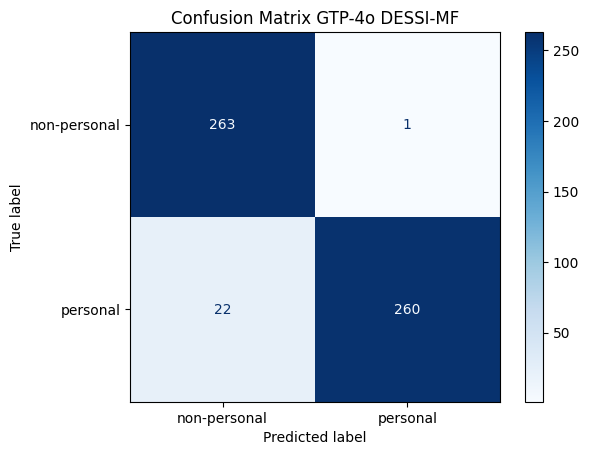

In [112]:
import matplotlib.pyplot as plt
# Compute confusion matrix
cm = confusion_matrix(y_true_dessib, y_pred_dessib)

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['non-personal', 'personal'])

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)  # You can customize the colormap here
plt.title('Confusion Matrix GTP-4o DESSI-MF')
plt.show()

        Evaluation 0.7

In [199]:
predict_gpt_07 = pd.read_csv('../GPT/dessimf_predictions_batch_gpt07.csv')
predict_gpt_07['batch_gpt_prediction']= predict_gpt_07['batch_gpt_prediction'].fillna('')
y_pred_07 = load_predictions_csv(predict_gpt_07)

In [200]:
predict_gpt_07['Feature']

0                   drink_mixed_mimesis
1                        MnTvnRO2qGFq56
2                       city_en_mimesis
3      credit_card_provider_de_DE_faker
4                  48i2GDrmZhvkUDPqTlaV
                     ...               
541                         Gqi7w4e4pxs
542              phone_model_fr_mimesis
543                        sex_en_faker
544                         XKANObF4OIs
545          manufacturer_mixed_mimesis
Name: Feature, Length: 546, dtype: object

In [201]:
y_true_dessib1 = results_own_dataset_personal["True Label"].values
y_pred_dessib1 = y_pred_07
target_names = ['non-personal', 'personal']
print(classification_report(y_true_dessib1, y_pred_dessib1, target_names=target_names))
f1_dessi_micro11 = f1_score(y_true_dessib1, y_pred_dessib1, average="micro")
print(f'micro f1:{f1_dessi_micro11}')
f1_dessi_macro11 = f1_score(y_true_dessib1, y_pred_dessib1, average="macro")
print(f'macro f1:{f1_dessi_macro11}')
f1_dessi_weighted11 = f1_score(y_true_dessib1, y_pred_dessib1, average="weighted")
print(f'weighted f1:{f1_dessi_weighted11}')
Balanced_accuracy11 = balanced_accuracy_score(y_true_dessib1, y_pred_dessib1)
print(f'Balanced accuracy:{Balanced_accuracy11}')

              precision    recall  f1-score   support

non-personal       0.92      0.99      0.95       264
    personal       0.99      0.92      0.95       282

    accuracy                           0.95       546
   macro avg       0.96      0.96      0.95       546
weighted avg       0.96      0.95      0.95       546

micro f1:0.9542124542124543
macro f1:0.9542123006222432
weighted f1:0.954209535998443
Balanced accuracy:0.9553110896196002


In [108]:
# False Negative 0.3, 0.7


In [109]:
#False negatives
results_own_dataset_personal.loc[(results_own_dataset_personal["True Label"] == "personal") & (results_own_dataset_personal["Prediction"] == "non-personal")]

,Column,True Label,Prediction,Classes,Predicted Classes,Dataset
49,ypqnvPf7C,personal,non-personal,ID_Card,,dessi
216,fUF0eWI,personal,non-personal,ssn_fr_FR,,faker
294,pBLzHfz3,personal,non-personal,passport_number_en,,faker
306,N9Vg8W,personal,non-personal,passport_number_mixed,,faker
367,VJvwSDrtqohUmuhVI8,personal,non-personal,credit_card_number_mixed,,mimesis
514,cosTsS3DeRo7qY,personal,non-personal,passport_number_fr_FR,,faker
522,RhALtY5U3SObMEq,personal,non-personal,passport_number_de_DE,,faker


All false negatives have corrupted column names and have except the address number values

In [110]:
#False positives
results_own_dataset_personal.loc[(results_own_dataset_personal["True Label"] == "non-personal") & (results_own_dataset_personal["Prediction"] == "personal")]

,Column,True Label,Prediction,Classes,Predicted Classes,Dataset
263,TSyFzpjPSa5,non-personal,personal,company_fr_FR,last_name,faker
275,155sXZoMZwoOmNqRWUXQ,non-personal,personal,ean_de_DE,credit_card_number,faker
295,dJp62hDiZDQHJMu8W5C,non-personal,personal,company_de_DE,"company,last_name",faker


In [111]:
CLASS_NAMES = results_own_dataset_personal["Classes"].unique()
CLASS_NAMES = [a.lower().split("_")[0] for a in CLASS_NAMES]

def is_valid_word(word):
    return word.lower().split("_")[0] in CLASS_NAMES

def create_analysis_plot(results_df, title, dataset="own_data"):
    cla_new, lan = [], []
    for i in range(len(results_df["Classes"])):
        if "mixed" in results_df.iloc[i, 3] or "de_DE" in results_df.iloc[i, 3] or "fr_FR" in results_df.iloc[i, 3]:
            cla_new.append(results_df.iloc[i, 3][:-6])
        elif "_en" in results_df.iloc[i, 3] or "_de" in results_df.iloc[i, 3] or "_fr" in results_df.iloc[i, 3] or "_it" in results_df.iloc[i,3
                                                                        ] or "_zh" in results_df.iloc[i,3]:
            cla_new.append(results_df.iloc[i, 3][:-3])
        else:
            cla_new.append(results_df.iloc[i, 3])
            
        if "mixed" in results_df.iloc[i, 3]:
            lan.append("mixed language")
        elif "_fr" == results_df.iloc[i,3][-3:].lower():
            lan.append("french")
        elif "_it" == results_df.iloc[i,3][-3:].lower():
            lan.append("italian")
        elif "_zh" == results_df.iloc[i,3][-3:].lower():
            lan.append("chinese")
        elif "_de" == results_df.iloc[i,3][-3:].lower():
            lan.append("german")
        elif "_en" == results_df.iloc[i,3][-3:].lower():
            lan.append("english")
        else:
            lan.append("dessi data")
    results_df["Classes_new"] = cla_new
    results_df["Language"] = lan
    

    accuracies_lan = {}
    for i in results_df["Language"].unique():
        lan_df = results_df.loc[results_df["Language"] == i]
        accuracies_lan[i] = accuracy_score(lan_df["True Label"], lan_df["Prediction"])
    accuracies_cla = {}
    for i in results_df["Classes_new"].unique():
        cla_df = results_df.loc[results_df["Classes_new"] == i]
        accuracies_cla[i] = accuracy_score(cla_df["True Label"], cla_df["Prediction"])
    accuracies_dat = {}
    for i in results_df["Dataset"].unique():
        dat_df = results_df.loc[results_df["Dataset"] == i]
        accuracies_dat[i] = accuracy_score(dat_df["True Label"], dat_df["Prediction"])
    accuracies_col = {}
    ind = []
    for i in range(results_df.shape[0]):
        if is_valid_word(results_df.iloc[i, 0]):
            ind.append(i)
    accuracies_col["valid_col_names"] = accuracy_score(results_df.iloc[ind, 2], results_df.iloc[ind, 1])
    accuracies_col["invalid_col_names"] = accuracy_score(results_df.iloc[[a for a in range(results_df.shape[0]) if a not in ind], 2], 
                                                        results_df.iloc[[a for a in range(results_df.shape[0]) if a not in ind], 1])

    accuracies_cla = dict(sorted(accuracies_cla.items(), key=lambda item: item[1], reverse=True))
    accuracies_lan = dict(sorted(accuracies_lan.items(), key=lambda item: item[1], reverse=True))
    accuracies_col = dict(sorted(accuracies_col.items(), key=lambda item: item[1], reverse=True))
    accuracies_dat = dict(sorted(accuracies_dat.items(), key=lambda item: item[1], reverse=True))


    fig = make_subplots(rows=3, cols=1, subplot_titles=["Accuracy per Class", "Number of correct predictions per Class", "Number of false predictions per Class"],
                        vertical_spacing=0.065, shared_xaxes=True)
    fig.add_trace(go.Bar(
        x=list(accuracies_cla.keys()),
        y=list(accuracies_cla.values()),
        marker=dict(color="black"),
        showlegend=False
    ))
    
    colors = [
    "#d62728",  # Red (High Saturation)
    "#ff9896",  # Red (Low Saturation)
    "#1f77b4",  # Blue (High Saturation)
    "#aec7e8",  # Blue (Low Saturation)
    "#ff7f0e",  # Orange (High Saturation)
    "#ffbb78",  # Orange (Low Saturation)
    "#2ca02c",  # Green (High Saturation)
    "#98df8a",  # Green (Low Saturation)
    "#9467bd",  # Purple (High Saturation)
    "#c5b0d5",  # Purple (Low Saturation)
    ]

    languages = ['english', 'french', 'german', 'mixed language', 'dessi data'] if dataset != "two_languages" else ["italian", "chinese"]
    for bool_val in [True, False]:
        for e, language in enumerate(languages):
            lan_df = results_df.loc[results_df["Language"] == language]
            accuracies_cla = {}
            for ee, col_valid in enumerate([True, False]):
                percentage_of_this_language = []
                for i in lan_df["Classes_new"].unique():
                    cla_df = lan_df.loc[lan_df["Classes_new"] == i]
                    ind = []
                    for j in range(cla_df.shape[0]):
                        if is_valid_word(cla_df.iloc[j, 0]) == col_valid:
                            ind.append(j)
                    cla_df = cla_df.iloc[ind,:]
                    percentage_of_this_language.append(cla_df.shape[0] / results_df.loc[results_df["Classes_new"] == i].shape[0])
                    accuracies_cla[i] = (cla_df["True Label"] == cla_df["Prediction"]).value_counts(normalize=True).get(bool_val, 0)
                fig.add_trace(go.Bar(
                    x=list(accuracies_cla.keys()),
                    y=[a * b for a, b in zip(list(accuracies_cla.values()), percentage_of_this_language)],
                    marker=dict(color=colors[2*e+ee]),
                    name=f"{language}_" + ("valid" if col_valid == True else "invalid") + "<br>column name",
                    showlegend=True if bool_val == True else False,
                    legendgroup=2*e+ee
                ), row=2 if bool_val == True else 3, col=1)
    fig.update_layout(title=f"Accuracy per Class for GPT's {title}", width=1500, height=700, barmode="stack")
    fig.update_yaxes(title_text="Accuracy", row=1, col=1)
    fig.update_yaxes(title_text="Amount of<br>correct predictions", row=2, col=1)
    fig.update_yaxes(title_text="Amount of<br>false predictions", range=[0,1.1], row=3, col=1)
    fig.show()

    fig = make_subplots(
        rows=1, cols=3, shared_yaxes=True,
        subplot_titles=["Accuracy per Language", "Accuracy per Dataset", "Accuracy per Column Name"]
    )
    fig.add_trace(go.Bar(
        x=list(accuracies_lan.keys()),
        y=list(accuracies_lan.values()),
        showlegend=False
    ), row=1, col=1)
    fig.add_trace(go.Bar(
        x=list(accuracies_dat.keys()),
        y=list(accuracies_dat.values()),
        showlegend=False
    ), row=1, col=2)
    fig.add_trace(go.Bar(
        x=list(accuracies_col.keys()),
        y=list(accuracies_col.values()),
        showlegend=False
    ), row=1, col=3)
    fig.update_layout(width=900, height=500, title=f"Accuracy of GPT's {title} with respect to different categories")
    fig.show()

In [112]:
create_analysis_plot(results_own_dataset_personal, "personal predictions on dessi-mf")

# Test two languages

In [25]:
predictions_test_languages, detected_classes_test_languages = load_predictions("gpt_predictions/test_languages_results.txt")

In [26]:
results_test_languages_personal = pd.DataFrame({
    "Column": test_lan.columns,
    "True Label": test_lan_personal["label"],
    "Prediction": predictions_test_languages,
    "Classes": test_lan_classes["class"],
    "Predicted Classes": detected_classes_test_languages,
    "Dataset": test_lan_datasets["dataset"]
})

In [27]:
plot_gpt_results(results_test_languages_personal, "GPT Prediction on test languages")

In [28]:
y_true_lang = results_test_languages_personal["True Label"].values
y_pred_lang = results_test_languages_personal["Prediction"].values
target_names = ['non-personal', 'personal']
print(classification_report(y_true_lang, y_pred_lang, target_names=target_names))
f1_lang_micro = f1_score(y_true_lang, y_pred_lang, average="micro")
print(f'micro f1:{f1_lang_micro}')
f1_lang_macro = f1_score(y_true_lang, y_pred_lang, average="macro")
print(f'macro f1:{f1_lang_macro}')
f1_lang_weighted = f1_score(y_true_lang, y_pred_lang, average="weighted")
print(f'weighted f1:{f1_lang_weighted}')
Balanced_accuracylan = balanced_accuracy_score(y_true_lang, y_pred_lang)
print(f'Balanced accuracy:{Balanced_accuracylan}')


              precision    recall  f1-score   support

non-personal       0.97      1.00      0.99        36
    personal       1.00      0.98      0.99        64

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100

micro f1:0.99
macro f1:0.9892136770574911
weighted f1:0.9900291230719448
Balanced accuracy:0.9921875


        Eval lan 0.3

In [29]:
predict_gpt_lan03 = pd.read_csv('../GPT/Lan_predictions_batch_gpt03.csv')
predict_gpt_lan03['batch_gpt_prediction']= predict_gpt_lan03['batch_gpt_prediction'].fillna('')
y_pred_lan03 = load_predictions_csv(predict_gpt_lan03)

In [30]:
predict_gpt_lan03

,Feature,batch_gpt_prediction
0,academic_degree_it_1,academic_degree/title
1,Fbh7x41Ztpdp4K8,job
2,first_name_zh_1,first_name
3,address_it_1,full_address
4,aeTOdoe5c3ve,religion/worldview
...,...,...
95,VCJTBJahe8,email
96,phone_number_zh_1,phone_number
97,ssn_zh_1,national_identification_number
98,blV7vY7AZQ3VZprkYS,url


In [202]:
y_true_lang1 = results_test_languages_personal["True Label"].values
y_pred_lang1 = y_pred_lan03
target_names = ['non-personal', 'personal']
print(classification_report(y_true_lang1, y_pred_lang1, target_names=target_names))
f1_lang_micro1 = f1_score(y_true_lang1, y_pred_lang1, average="micro")
print(f'micro f1:{f1_lang_micro1}')
f1_lang_macro1 = f1_score(y_true_lang1, y_pred_lang1, average="macro")
print(f'macro f1:{f1_lang_macro1}')
f1_lang_weighted1 = f1_score(y_true_lang1, y_pred_lang1, average="weighted")
print(f'weighted f1:{f1_lang_weighted1}')
Balanced_accuracylan1 = balanced_accuracy_score(y_true_lang1, y_pred_lang1)
print(f'Balanced accuracy:{Balanced_accuracylan1}')

              precision    recall  f1-score   support

non-personal       0.97      1.00      0.99        36
    personal       1.00      0.98      0.99        64

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100

micro f1:0.99
macro f1:0.9892136770574911
weighted f1:0.9900291230719448
Balanced accuracy:0.9921875


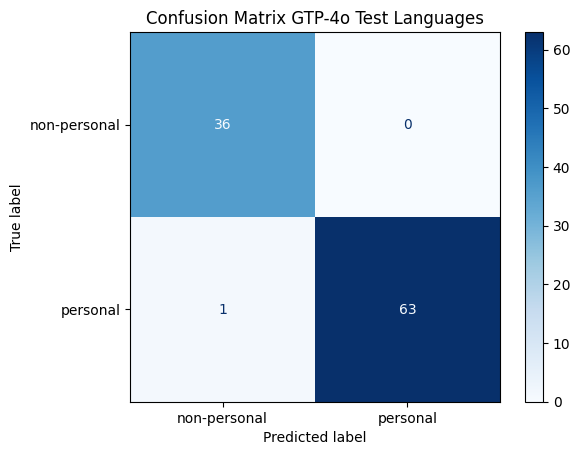

In [203]:
# Compute confusion matrix
cm1 = confusion_matrix(y_true_lang1, y_pred_lang1)

# Create a ConfusionMatrixDisplay object
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=['non-personal', 'personal'])

# Plot the confusion matrix
disp1.plot(cmap=plt.cm.Blues)  # You can customize the colormap here
plt.title('Confusion Matrix GTP-4o Test Languages')
plt.show()

        Eval lan 0.7

In [130]:
predict_gpt_lan07 = pd.read_csv('../GPT/Lan_predictions_batch_gpt07.csv')
predict_gpt_lan07['batch_gpt_prediction']= predict_gpt_lan07['batch_gpt_prediction'].fillna('')
y_pred_lan07 = load_predictions_csv(predict_gpt_lan07)

In [146]:
y_true_lang11 = results_test_languages_personal["True Label"].values
y_pred_lang11 = y_pred_lan07
target_names = ['non-personal', 'personal']
print(classification_report(y_true_lang11, y_pred_lang11, target_names=target_names))
f1_lang_micro11 = f1_score(y_true_lang11, y_pred_lang11, average="micro")
print(f'micro f1:{f1_lang_micro11}')
f1_lang_macro11 = f1_score(y_true_lang11, y_pred_lang11, average="macro")
print(f'macro f1:{f1_lang_macro11}')
f1_lang_weighted11 = f1_score(y_true_lang11, y_pred_lang11, average="weighted")
print(f'weighted f1:{f1_lang_weighted11}')
Balanced_accuracylan11 = balanced_accuracy_score(y_true_lang11, y_pred_lang11)
print(f'Balanced accuracy:{Balanced_accuracylan11}')

              precision    recall  f1-score   support

non-personal       0.97      1.00      0.99        36
    personal       1.00      0.98      0.99        64

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100

micro f1:0.99
macro f1:0.9892136770574911
weighted f1:0.9900291230719448
Balanced accuracy:0.9921875


In [127]:
#check the NAN instances
#predict_gpt_lan03[predict_gpt_lan03['batch_gpt_prediction'].isnull()]


In [33]:
#False negatives
results_test_languages_personal.loc[(results_test_languages_personal["True Label"] == "personal") & (results_test_languages_personal["Prediction"] == "non-personal")]

,Column,True Label,Prediction,Classes,Predicted Classes,Dataset
26,GWlG6g3Ot1OGM,personal,non-personal,nationality_zh,gpe,mimesis


All false negatives have corrupted column names and have except the address number values

In [34]:
#False positives
results_test_languages_personal.loc[(results_test_languages_personal["True Label"] == "non-personal") & (results_test_languages_personal["Prediction"] == "personal")]

,Column,True Label,Prediction,Classes,Predicted Classes,Dataset


In [36]:
# create_analysis_plot(results_test_languages_personal, "personal predictions on test languages", dataset="two_languages")

# Kaggle Datasets

In [37]:
def load_predictions_dataset(path, data, labels, dataset):
    with open(path, "r") as f:
        response_text = f.read()
    responses = response_text.split("\n")[1:]
    personal = []
    for j in range(data.shape[1]):
        col = data.columns[j]
        col = col.replace("(", "\(").replace(")", "\)").replace("$", "\$")          # escape special characters for pattern matching
        match1 = re.search(f"({col}|'{col}'|\"{col}\")" +
                        f": (true|false|\"true\"|\"false\"|'true'|'false'|True|False|\"True\"|\"False\"|'True'|'False')",
                        responses[j])
        personal.append(match1.group(2))
    personal_transformed = ["non-personal" if "false" in a.lower() else "personal" for a in personal]
    
    results = pd.DataFrame({
        "Name": data.columns,
        "True Label": labels["label"],
        "Prediction": personal_transformed,
        "Dataset": dataset["dataset"]
    })
    return results

In [38]:
def load_predictions_other_csv(batch_pred_csv):
    batch_pred_csv['batch_gpt_prediction'] = batch_pred_csv['batch_gpt_prediction'].fillna('')

    personal_transformed_other = []
    for i in batch_pred_csv['batch_gpt_prediction']:
        if i==True:                    
            personal_transformed_other.append("personal")
        else:
            personal_transformed_other.append("non-personal")
    return personal_transformed_other

In [39]:
results_kaggle_personal = load_predictions_dataset("gpt_predictions/kaggle_results.txt", kaggle_data, kaggle_labels, kaggle_dataset)

In [40]:
plot_gpt_results(results_kaggle_personal, title="GPT's prediction on Kaggle datasets")

In [41]:
#False negatives
fn_df = results_kaggle_personal.loc[(results_kaggle_personal["True Label"] == "personal") & (results_kaggle_personal["Prediction"] == "non-personal")]
fn_df

,Name,True Label,Prediction,Dataset
2,Month of absence,personal,non-personal,absenteeism
3,Day of the week,personal,non-personal,absenteeism
4,Seasons,personal,non-personal,absenteeism
5,Transportation expense,personal,non-personal,absenteeism
7,Service time,personal,non-personal,absenteeism
9,Work load Average/day,personal,non-personal,absenteeism
10,Hit target,personal,non-personal,absenteeism
31,capital.gain,personal,non-personal,adult_census
55,contact,personal,non-personal,bank_marketing
56,month,personal,non-personal,bank_marketing


In [42]:
fn_df["Dataset"].value_counts()

Dataset
absenteeism            7
bank_marketing         4
graduate_admissions    4
phishing_email         4
titanic                3
heart_disease          2
adult_census           1
student_performance    1
Name: count, dtype: int64

In [43]:
y_true_kagg = results_kaggle_personal["True Label"].values
y_pred_kagg = results_kaggle_personal["Prediction"].values
target_names = ['non-personal', 'personal']
print(classification_report(y_true_kagg, y_pred_kagg, target_names=target_names))
f1_kagg_micro = f1_score(y_true_kagg, y_pred_kagg, average="micro")
print(f'micro f1:{f1_kagg_micro}')
f1_kagg_macro = f1_score(y_true_kagg, y_pred_kagg, average="macro")
print(f'macro f1:{f1_kagg_macro}')
f1_kagg_weighted = f1_score(y_true_kagg, y_pred_kagg, average="weighted")
print(f'weighted f1:{f1_kagg_weighted}')

              precision    recall  f1-score   support

non-personal       0.77      0.93      0.84        91
    personal       0.96      0.83      0.89       155

    accuracy                           0.87       246
   macro avg       0.86      0.88      0.87       246
weighted avg       0.89      0.87      0.87       246

micro f1:0.8699186991869918
macro f1:0.8656196654148174
weighted f1:0.8718728054470712


        Eval kaggle 0.3

In [46]:
predict_gpt_kag03 = pd.read_csv('../GPT/kaggle_predictions_batch_gpt03.csv')
predict_gpt_kag03['batch_gpt_prediction']= predict_gpt_kag03['batch_gpt_prediction'].fillna('')
y_pred_kag03 = load_predictions_other_csv(predict_gpt_kag03)

In [204]:
y_true_kag1 = results_kaggle_personal["True Label"].values
y_pred_kag1 = y_pred_kag03
target_names = ['non-personal', 'personal']
print(classification_report(y_true_kag1, y_pred_kag1, target_names=target_names))
f1_kag_micro1 = f1_score(y_true_kag1, y_pred_kag1, average="micro")
print(f'micro f1:{f1_kag_micro1}')
f1_kag_macro1 = f1_score(y_true_kag1, y_pred_kag1, average="macro")
print(f'macro f1:{f1_kag_macro1}')
f1_kag_weighted1 = f1_score(y_true_kag1, y_pred_kag1, average="weighted")
print(f'weighted f1:{f1_kag_weighted1}')
Balanced_accuracykag1 = balanced_accuracy_score(y_true_kag1, y_pred_kag1)
print(f'Balanced accuracy:{Balanced_accuracykag1}')

              precision    recall  f1-score   support

non-personal       0.84      0.92      0.88        91
    personal       0.95      0.90      0.92       155

    accuracy                           0.91       246
   macro avg       0.90      0.91      0.90       246
weighted avg       0.91      0.91      0.91       246

micro f1:0.9065040650406504
macro f1:0.9015845958497852
weighted f1:0.9073090690900648
Balanced accuracy:0.9099255583126551


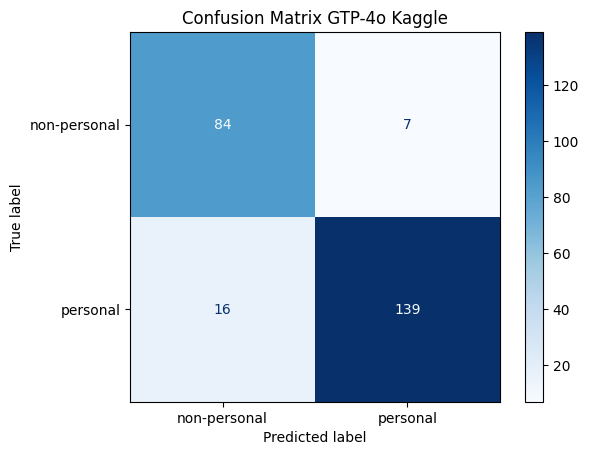

In [205]:
# Compute confusion matrix
cmkag = confusion_matrix(y_true_kag1, y_pred_kag1)

# Create a ConfusionMatrixDisplay object
dispkag = ConfusionMatrixDisplay(confusion_matrix=cmkag, display_labels=['non-personal', 'personal'])

# Plot the confusion matrix
dispkag.plot(cmap=plt.cm.Blues)  # You can customize the colormap here
plt.title('Confusion Matrix GTP-4o Kaggle')
plt.show()

        Eval 0.7

In [172]:
predict_gpt_kag07 = pd.read_csv('../GPT/kaggle_predictions_batch_gpt07.csv')
#predict_gpt_kag07['batch_gpt_prediction']= predict_gpt_kag07['batch_gpt_prediction'].fillna('')
y_pred_kag07 = load_predictions_other_csv(predict_gpt_kag07)

In [173]:
y_true_kag11 = results_kaggle_personal["True Label"].values
y_pred_kag11 = y_pred_kag07
target_names = ['non-personal', 'personal']
print(classification_report(y_true_kag11, y_pred_kag11, target_names=target_names))
f1_kag_micro11 = f1_score(y_true_kag11, y_pred_kag11, average="micro")
print(f'micro f1:{f1_kag_micro11}')
f1_kag_macro11 = f1_score(y_true_kag11, y_pred_kag11, average="macro")
print(f'macro f1:{f1_kag_macro11}')
f1_kag_weighted11 = f1_score(y_true_kag11, y_pred_kag11, average="weighted")
print(f'weighted f1:{f1_kag_weighted11}')
Balanced_accuracykag11 = balanced_accuracy_score(y_true_kag11, y_pred_kag11)
print(f'Balanced accuracy:{Balanced_accuracykag11}')

              precision    recall  f1-score   support

non-personal       0.81      0.93      0.87        91
    personal       0.96      0.87      0.91       155

    accuracy                           0.89       246
   macro avg       0.88      0.90      0.89       246
weighted avg       0.90      0.89      0.90       246

micro f1:0.8943089430894309
macro f1:0.8897545504688362
weighted f1:0.8955841730231974
Balanced accuracy:0.9025168380007089


In [51]:
#False positives
results_kaggle_personal.loc[(results_kaggle_personal["True Label"] == "non-personal") & (results_kaggle_personal["Prediction"] == "personal")]

,Name,True Label,Prediction,Dataset
23,fnlwgt,non-personal,personal,adult_census
111,fullAddress,non-personal,personal,house_price
153,EMAIL_ADDR,non-personal,personal,indian_companies
179,director,non-personal,personal,pixar
180,writer,non-personal,personal,pixar
183,main_voice_actors,non-personal,personal,pixar


# OpenML Datasets

In [50]:
results_openml_personal = load_predictions_dataset("gpt_predictions/openml_results.txt", openml_data, openml_labels, openml_dataset)

In [51]:
plot_gpt_results(results_openml_personal, title="GPT's prediction on OpenML datasets")

In [52]:
y_true_open1 = results_openml_personal["True Label"].values
y_pred_open1 = results_openml_personal["Prediction"].values
target_names = ['non-personal', 'personal']
print(classification_report(y_true_open1, y_pred_open1, target_names=target_names))
f1_open1_micro = f1_score(y_true_open1, y_pred_open1, average="micro")
print(f'micro f1:{f1_open1_micro}')
f1_open1_macro = f1_score(y_true_open1, y_pred_open1, average="macro")
print(f'macro f1:{f1_open1_macro}')
f1_open1_weighted = f1_score(y_true_open1, y_pred_open1, average="weighted")
print(f'weighted f1:{f1_open1_weighted}')

              precision    recall  f1-score   support

non-personal       0.93      0.97      0.95        72
    personal       0.97      0.93      0.95        70

    accuracy                           0.95       142
   macro avg       0.95      0.95      0.95       142
weighted avg       0.95      0.95      0.95       142

micro f1:0.9507042253521126
macro f1:0.9506430309350017
weighted f1:0.9506675087018462


    Eval open1 0.3

In [55]:
predict_gpt_open103 = pd.read_csv('../GPT/open1_predictions_batch_gpt03.csv')
#predict_gpt_kag07['batch_gpt_prediction']= predict_gpt_kag07['batch_gpt_prediction'].fillna('')
y_pred_open103 = load_predictions_other_csv(predict_gpt_open103)

In [56]:
y_true_open11 = results_openml_personal["True Label"].values
y_pred_open11 = y_pred_open103
target_names = ['non-personal', 'personal']
print(classification_report(y_true_open11, y_pred_open11, target_names=target_names))
f1_open1_micro1 = f1_score(y_true_open11, y_pred_open11, average="micro")
print(f'micro f1:{f1_open1_micro1}')
f1_open1_macro1 = f1_score(y_true_open11, y_pred_open11, average="macro")
print(f'macro f1:{f1_open1_macro1}')
f1_open1_weighted1 = f1_score(y_true_open11, y_pred_open11, average="weighted")
print(f'weighted f1:{f1_open1_weighted1}')
Balanced_accuracyopen1= balanced_accuracy_score(y_true_open11, y_pred_open11)
print(f'Balanced accuracy:{Balanced_accuracyopen1}')

              precision    recall  f1-score   support

non-personal       0.97      0.96      0.97        72
    personal       0.96      0.97      0.96        70

    accuracy                           0.96       142
   macro avg       0.96      0.96      0.96       142
weighted avg       0.96      0.96      0.96       142

micro f1:0.9647887323943662
macro f1:0.9647869860635818
weighted f1:0.9647904787251506
Balanced accuracy:0.9648809523809524


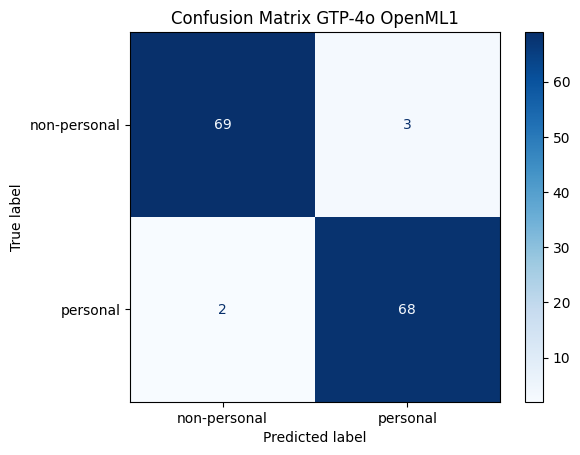

In [115]:
# Compute confusion matrix
cmopen1 = confusion_matrix(y_true_open11, y_pred_open11)

# Create a ConfusionMatrixDisplay object
dispopen1 = ConfusionMatrixDisplay(confusion_matrix=cmopen1, display_labels=['non-personal', 'personal'])

# Plot the confusion matrix
dispopen1.plot(cmap=plt.cm.Blues)  # You can customize the colormap here
plt.title('Confusion Matrix GTP-4o OpenML1')
plt.show()

        Eval open1 0.7

In [58]:
predict_gpt_open107 = pd.read_csv('../GPT/open1_predictions_batch_gpt07.csv')
#predict_gpt_kag07['batch_gpt_prediction']= predict_gpt_kag07['batch_gpt_prediction'].fillna('')
y_pred_open107 = load_predictions_other_csv(predict_gpt_open107)

In [59]:
y_true_open111 = results_openml_personal["True Label"].values
y_pred_open111 = y_pred_open107
target_names = ['non-personal', 'personal']
print(classification_report(y_true_open111, y_pred_open111, target_names=target_names))
f1_open1_micro11 = f1_score(y_true_open111, y_pred_open111, average="micro")
print(f'micro f1:{f1_open1_micro1}')
f1_open1_macro11 = f1_score(y_true_open111, y_pred_open111, average="macro")
print(f'macro f1:{f1_open1_macro11}')
f1_open1_weighted11 = f1_score(y_true_open111, y_pred_open111, average="weighted")
print(f'weighted f1:{f1_open1_weighted11}')
Balanced_accuracyopen11= balanced_accuracy_score(y_true_open111, y_pred_open111)
print(f'Balanced accuracy:{Balanced_accuracyopen11}')

              precision    recall  f1-score   support

non-personal       0.93      0.94      0.94        72
    personal       0.94      0.93      0.94        70

    accuracy                           0.94       142
   macro avg       0.94      0.94      0.94       142
weighted avg       0.94      0.94      0.94       142

micro f1:0.9647887323943662
macro f1:0.9365914165219549
weighted f1:0.9366102843805577
Balanced accuracy:0.9365079365079365


In [60]:
#False negatives
results_openml_personal.loc[(results_openml_personal["True Label"] == "personal") & (results_openml_personal["Prediction"] == "non-personal")]

,Name,True Label,Prediction,Dataset
15,Devices Used,personal,non-personal,Amazon_Prime_Fiction
118,V9,personal,non-personal,TVS_Loan_Default
119,V10,personal,non-personal,TVS_Loan_Default
121,V12,personal,non-personal,TVS_Loan_Default
134,V25,personal,non-personal,TVS_Loan_Default


In [35]:
#False positives
results_openml_personal.loc[(results_openml_personal["True Label"] == "non-personal") & (results_openml_personal["Prediction"] == "personal")]

,Name,True Label,Prediction,Dataset
27,Referee,non-personal,personal,APL_20_24
86,Address,non-personal,personal,HousingPrices


# OpenML 2 Datasets

In [61]:
results_openml_2_personal = load_predictions_dataset("gpt_predictions/openml_2_results.txt", openml_2_data, openml_2_labels, openml_2_dataset)

In [62]:
plot_gpt_results(results_openml_2_personal, title="GPT's prediction on OpenML 2 datasets")

In [63]:
y_true_open2 = results_openml_2_personal["True Label"].values
y_pred_open2 = results_openml_2_personal["Prediction"].values
target_names = ['non-personal', 'personal']
print(classification_report(y_true_open2, y_pred_open2, target_names=target_names))
f1_open2_micro = f1_score(y_true_open2, y_pred_open2, average="micro")
print(f'micro f1:{f1_open2_micro}')
f1_open2_macro = f1_score(y_true_open2, y_pred_open2, average="macro")
print(f'macro f1:{f1_open2_macro}')
f1_open2_weighted = f1_score(y_true_open2, y_pred_open2, average="weighted")
print(f'weighted f1:{f1_open2_weighted}')

              precision    recall  f1-score   support

non-personal       0.98      0.99      0.99       104
    personal       0.91      0.83      0.87        12

    accuracy                           0.97       116
   macro avg       0.95      0.91      0.93       116
weighted avg       0.97      0.97      0.97       116

micro f1:0.9741379310344828
macro f1:0.9276055752028292
weighted f1:0.9736375831223145


        Eval open2 0.3

In [64]:
predict_gpt_open203 = pd.read_csv('../GPT/open2_predictions_batch_gpt03.csv')
#predict_gpt_kag07['batch_gpt_prediction']= predict_gpt_kag07['batch_gpt_prediction'].fillna('')
y_pred_open203 = load_predictions_other_csv(predict_gpt_open203)

In [66]:
y_true_open21 = results_openml_2_personal["True Label"].values
y_pred_open21 = y_pred_open203
target_names = ['non-personal', 'personal']
print(classification_report(y_true_open21, y_pred_open21, target_names=target_names))
f1_open2_micro1 = f1_score(y_true_open21, y_pred_open21, average="micro")
print(f'micro f1:{f1_open2_micro1}')
f1_open2_macro1 = f1_score(y_true_open21, y_pred_open21, average="macro")
print(f'macro f1:{f1_open2_macro1}')
f1_open2_weighted1 = f1_score(y_true_open21, y_pred_open21, average="weighted")
print(f'weighted f1:{f1_open2_weighted1}')
Balanced_accuracyopen21= balanced_accuracy_score(y_true_open21, y_pred_open21)
print(f'Balanced accuracy:{Balanced_accuracyopen21}')

              precision    recall  f1-score   support

non-personal       0.99      1.00      1.00       104
    personal       1.00      0.92      0.96        12

    accuracy                           0.99       116
   macro avg       1.00      0.96      0.98       116
weighted avg       0.99      0.99      0.99       116

micro f1:0.9913793103448276
macro f1:0.9758685250676098
weighted f1:0.9912125277074382
Balanced accuracy:0.9583333333333333


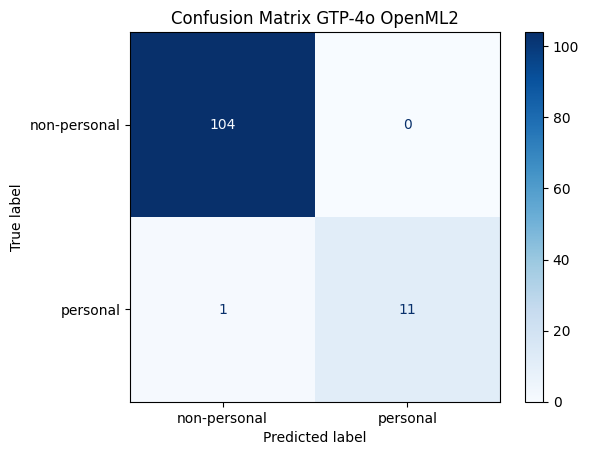

In [116]:
# Compute confusion matrix
cmopen2 = confusion_matrix(y_true_open21, y_pred_open21)

# Create a ConfusionMatrixDisplay object
dispopen2 = ConfusionMatrixDisplay(confusion_matrix=cmopen2, display_labels=['non-personal', 'personal'])

# Plot the confusion matrix
dispopen2.plot(cmap=plt.cm.Blues)  # You can customize the colormap here
plt.title('Confusion Matrix GTP-4o OpenML2')
plt.show()

        Eval open2 0.7

In [68]:
predict_gpt_open207 = pd.read_csv('../GPT/open2_predictions_batch_gpt07.csv')
#predict_gpt_kag07['batch_gpt_prediction']= predict_gpt_kag07['batch_gpt_prediction'].fillna('')
y_pred_open207 = load_predictions_other_csv(predict_gpt_open207)

In [69]:
y_true_open211 = results_openml_2_personal["True Label"].values
y_pred_open211 = y_pred_open207
target_names = ['non-personal', 'personal']
print(classification_report(y_true_open211, y_pred_open211, target_names=target_names))
f1_open2_micro11 = f1_score(y_true_open211, y_pred_open211, average="micro")
print(f'micro f1:{f1_open2_micro11}')
f1_open2_macro11 = f1_score(y_true_open211, y_pred_open211, average="macro")
print(f'macro f1:{f1_open2_macro11}')
f1_open2_weighted11 = f1_score(y_true_open211, y_pred_open211, average="weighted")
print(f'weighted f1:{f1_open2_weighted11}')
Balanced_accuracyopen211= balanced_accuracy_score(y_true_open211, y_pred_open211)
print(f'Balanced accuracy:{Balanced_accuracyopen211}')

              precision    recall  f1-score   support

non-personal       0.99      1.00      1.00       104
    personal       1.00      0.92      0.96        12

    accuracy                           0.99       116
   macro avg       1.00      0.96      0.98       116
weighted avg       0.99      0.99      0.99       116

micro f1:0.9913793103448276
macro f1:0.9758685250676098
weighted f1:0.9912125277074382
Balanced accuracy:0.9583333333333333


In [70]:
len(results_openml_2_personal[results_openml_2_personal["Prediction"] == "personal"])

11

In [71]:
#False negatives
results_openml_2_personal.loc[(results_openml_2_personal["True Label"] == "personal") & (results_openml_2_personal["Prediction"] == "non-personal")]

,Name,True Label,Prediction,Dataset
21,wall_index,personal,non-personal,echoMonths
23,class,personal,non-personal,echoMonths


In [72]:
#False positives
results_openml_2_personal.loc[(results_openml_2_personal["True Label"] == "non-personal") & (results_openml_2_personal["Prediction"] == "personal")]

,Name,True Label,Prediction,Dataset
90,tip_amount,non-personal,personal,nyc-taxi-green-dec-2016


## OpenML ALL

In [73]:
predict_gpt_openall = pd.read_csv('../GPT/openall_predictions_batch_gpt031.csv')
#predict_gpt_kag07['batch_gpt_prediction']= predict_gpt_kag07['batch_gpt_prediction'].fillna('')
y_pred_openall1 = load_predictions_other_csv(predict_gpt_openall)

In [74]:
y_true_all = pd.read_csv('/home/aagisha/Documents/PhD Albert/CodingPhDStart1/Bachelor Projects HSAA/PIIDETECTION/Personal-Detection/datasets/OpenMLall_data/OpenMLAll_data_labels.csv')

In [75]:
y_true_all

,label
0,personal
1,personal
2,personal
3,personal
4,personal
...,...
253,non-personal
254,non-personal
255,non-personal
256,non-personal


In [206]:
y_true_openall = y_true_all
y_pred_openall = y_pred_openall1
target_names = ['non-personal', 'personal']
print(classification_report(y_true_openall, y_pred_openall, target_names=target_names))
f1_openall_micro1 = f1_score(y_true_openall, y_pred_openall, average="micro")
print(f'micro f1:{f1_openall_micro1}')
f1_openall_macro1 = f1_score(y_true_openall, y_pred_openall, average="macro")
print(f'macro f1:{f1_openall_macro1}')
f1_openall_weighted1 = f1_score(y_true_openall, y_pred_openall, average="weighted")
print(f'weighted f1:{f1_openall_weighted1}')
Balanced_accuracyopenall21= balanced_accuracy_score(y_true_openall, y_pred_openall)
print(f'Balanced accuracy:{Balanced_accuracyopenall21}')

              precision    recall  f1-score   support

non-personal       0.98      0.97      0.98       176
    personal       0.94      0.96      0.95        82

    accuracy                           0.97       258
   macro avg       0.96      0.97      0.96       258
weighted avg       0.97      0.97      0.97       258

micro f1:0.9689922480620154
macro f1:0.9644750430292599
weighted f1:0.9690904481714231
Balanced accuracy:0.9675027716186253


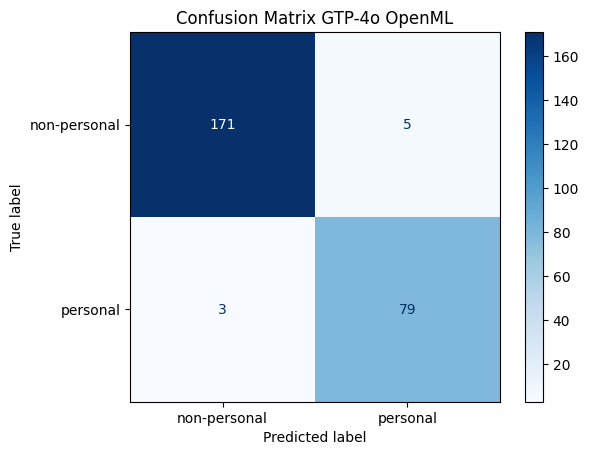

In [207]:
# Compute confusion matrix
cmopenall = confusion_matrix(y_true_openall, y_pred_openall)

# Create a ConfusionMatrixDisplay object
dispopenall = ConfusionMatrixDisplay(confusion_matrix=cmopenall, display_labels=['non-personal', 'personal'])

# Plot the confusion matrix
dispopenall.plot(cmap=plt.cm.Blues)  # You can customize the colormap here
plt.title('Confusion Matrix GTP-4o OpenML')
plt.show()

# Medical Dataset

In [79]:
with open("gpt_predictions/medical_results.txt", "r") as f:
    response_text = f.read()
responses = response_text.split("\n")[1:]
personal = []
for j in range(medical_data.shape[1]):
    col = medical_data.columns[j]
    col = col.replace("(", "\(").replace(")", "\)").replace("$", "\$")          # escape special characters for pattern matching
    match1 = re.search(f"({col}|'{col}'|\"{col}\")" +
                    f": (true|false|\"true\"|\"false\"|'true'|'false'|True|False|\"True\"|\"False\"|'True'|'False')",
                    responses[j])
    personal.append(match1.group(2))
personal_transformed = ["non-personal" if "false" in a.lower() else "personal" for a in personal]

results_medical_personal = pd.DataFrame({
    "Name": medical_data.columns,
    "True Label": medical_labels["label"],
    "Prediction": personal_transformed,
})

In [80]:
results_medical_personal

,Name,True Label,Prediction
0,encounter_id,personal,personal
1,patient_id,personal,personal
2,admission_type,personal,non-personal
3,admission_reason,personal,personal
4,last_encounter,personal,personal
5,birth_date,personal,personal
6,aids,personal,personal
7,wloss,personal,personal
8,alcohol,personal,personal
9,drug,personal,personal


In [119]:
results_personal = results_medical_personal
y_true = results_personal["True Label"].values
y_pred = results_personal["Prediction"].values
y_true_bin = [1 if label == "personal" else 0 for label in y_true]
y_pred_bin = [1 if label == "personal" else 0 for label in y_pred]

cm = confusion_matrix(y_true, y_pred, labels=["personal", "non-personal"])
cm_norm = confusion_matrix(y_true, y_pred, labels=["personal", "non-personal"], normalize="true")

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average="weighted")
precision = precision_score(y_true, y_pred, average="weighted", zero_division=0)
recall = recall_score(y_true, y_pred, average="weighted", zero_division=0)
#auc_roc = roc_auc_score(y_true_bin, y_pred_bin)

fig = make_subplots(
    rows=1, cols=2, 
    subplot_titles=["Evaluation Metrics", "Confusion Matrix"]
)

metrics = {
    "weighted Precision": precision,
    "weighted Recall": recall,
    "weighted F1 Score": f1,
    "Accuracy": accuracy,
 #   "AUC-ROC": auc_roc
}

fig.add_trace(go.Bar(
    x=list(metrics.keys()),
    y=list(metrics.values()), 
    showlegend=False
), row=1, col=1)

text_values = [
    [f"{cm[0,0]}<br>{cm_norm[0,0]:.2f}", f"{cm[0,1]}<br>{cm_norm[0,1]:.2f}"],
    [f"{cm[1,0]}<br>{cm_norm[1,0]:.2f}", f"{cm[1,1]}<br>{cm_norm[1,1]:.2f}"]
]
cm_heatmap = go.Heatmap(
    z=cm, 
    x=["Pred: personal", "Pred: non-personal"], 
    y=["True: personal", "True: non-personal"], 
    colorscale="Blues", 
    showscale=False,
    text=text_values, 
    texttemplate="%{text}",
    textfont={"size":20},
)

fig.add_trace(cm_heatmap, row=1, col=2)

fig.update_layout(
    title=f"Confusion Matrix and Evaluation Metrics for GPT's prediction on medical dataset",
    height=500, 
    width=1000,
    showlegend=False
)

fig.show()

In [82]:
y_true_med = results_medical_personal["True Label"].values
y_pred_med = results_medical_personal["Prediction"].values
target_names = ['non-personal', 'personal']
print(classification_report(y_true_med, y_pred_med, target_names=target_names, zero_division=1))
f1_med_micro = f1_score(y_true_med, y_pred_med, average="micro")
print(f'micro f1:{f1_med_micro}')
f1_med_macro = f1_score(y_true_med, y_pred_med, average="macro")
print(f'macro f1:{f1_med_macro}')
f1_med_weighted = f1_score(y_true_med, y_pred_med, average="weighted")
print(f'weighted f1:{f1_med_weighted}')
Balanced_accuracymed= balanced_accuracy_score(y_true_med, y_pred_med)
print(f'Balanced accuracy:{Balanced_accuracymed}')

              precision    recall  f1-score   support

non-personal       0.00      1.00      0.00         0
    personal       1.00      0.94      0.97        32

    accuracy                           0.94        32
   macro avg       0.50      0.97      0.48        32
weighted avg       1.00      0.94      0.97        32

micro f1:0.9375
macro f1:0.4838709677419355
weighted f1:0.967741935483871
Balanced accuracy:0.9375


/opt/anaconda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2458: UserWarning:

y_pred contains classes not in y_true



        Eval med 03

In [83]:
predict_gpt_med03 = pd.read_csv('../GPT/med_predictions_batch_gpt03.csv')
#predict_gpt_kag07['batch_gpt_prediction']= predict_gpt_kag07['batch_gpt_prediction'].fillna('')
y_pred_med_gpt103 = load_predictions_other_csv(predict_gpt_med03)

In [120]:
y_true_medgpt1 = results_medical_personal["True Label"].values
y_pred_medgpt1 = y_pred_med_gpt103
target_names = ['non-personal', 'personal']
print(classification_report(y_true_medgpt1, y_pred_medgpt1, target_names=target_names, zero_division=1))
f1_med_micro1 = f1_score(y_true_medgpt1, y_pred_medgpt1, average="micro")
print(f'micro f1:{f1_med_micro1}')
f1_med_macro1 = f1_score(y_true_medgpt1, y_pred_medgpt1, average="macro")
print(f'macro f1:{f1_med_macro1}')
f1_med_weighted1 = f1_score(y_true_medgpt1, y_pred_medgpt1, average="weighted")
print(f'weighted f1:{f1_med_weighted1}')

Balanced_accuracymed1= balanced_accuracy_score(y_true_medgpt1, y_pred_medgpt1)
print(f'Balanced accuracy:{Balanced_accuracymed1}')

              precision    recall  f1-score   support

non-personal       0.00      1.00      0.00         0
    personal       1.00      0.97      0.98        32

    accuracy                           0.97        32
   macro avg       0.50      0.98      0.49        32
weighted avg       1.00      0.97      0.98        32

micro f1:0.96875
macro f1:0.49206349206349204
weighted f1:0.9841269841269841
Balanced accuracy:0.96875


/opt/anaconda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2458: UserWarning:

y_pred contains classes not in y_true



        Eval med 07

In [222]:
predict_gpt_med07 = pd.read_csv('../GPT/med_predictions_batch_gpt07.csv')
#predict_gpt_kag07['batch_gpt_prediction']= predict_gpt_kag07['batch_gpt_prediction'].fillna('')
y_pred_med_gpt107 = load_predictions_other_csv(predict_gpt_med07)

In [231]:
y_pred_med_gpt107[31]='non-personal'

In [238]:
y_true_medgpt11 = results_medical_personal["True Label"].values
y_pred_medgpt11 = y_pred_med_gpt107
target_names = ['non-personal', 'personal']
print(classification_report(y_true_medgpt11, y_pred_medgpt11, target_names=target_names, zero_division=1))
f1_med_micro11 = f1_score(y_true_medgpt11, y_pred_medgpt11, average="micro")
print(f'micro f1:{f1_med_micro11}')
f1_med_macro11 = f1_score(y_true_medgpt11, y_pred_medgpt11, average="macro")
print(f'macro f1:{f1_med_macro11}')
f1_med_weighted11 = f1_score(y_true_medgpt11, y_pred_medgpt11, average="weighted")
print(f'weighted f1:{f1_med_weighted11}')

Balanced_accuracymed11= balanced_accuracy_score(y_true_medgpt11, y_pred_medgpt11)
print(f'Balanced accuracy:{Balanced_accuracymed11}')

              precision    recall  f1-score   support

non-personal       0.00      1.00      0.00         0
    personal       1.00      0.97      0.98        32

    accuracy                           0.97        32
   macro avg       0.50      0.98      0.49        32
weighted avg       1.00      0.97      0.98        32

micro f1:0.96875
macro f1:0.49206349206349204
weighted f1:0.9841269841269841
Balanced accuracy:0.96875


/opt/anaconda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2458: UserWarning:

y_pred contains classes not in y_true



In [45]:
#False negatives
results_medical_personal.loc[(results_medical_personal["True Label"] == "personal") & (results_medical_personal["Prediction"] == "non-personal")]

,Name,True Label,Prediction
2,admission_type,personal,non-personal
29,barbiturate,personal,non-personal


In [233]:
#False positives
results_medical_personal.loc[(results_medical_personal["True Label"] == "non-personal") & (results_medical_personal["Prediction"] == "personal")]

,Name,True Label,Prediction


# MIMIC III dataset

        Eval Mimic 03

In [85]:
predict_gpt_mimic03 = pd.read_csv('../GPT/mimic_predictions_batch_gpt03.csv')
#predict_gpt_kag07['batch_gpt_prediction']= predict_gpt_kag07['batch_gpt_prediction'].fillna('')
y_pred_mimic_gpt03 = load_predictions_other_csv(predict_gpt_mimic03)

In [186]:
y_true_Mimic = Mimic_labels03
y_pred_Mimic = y_pred_mimic_gpt03
target_names = ['non-personal', 'personal']
print(classification_report(y_true_Mimic, y_pred_Mimic, target_names=target_names, zero_division=1))
f1_mimic_micro1 = f1_score(y_true_Mimic, y_pred_Mimic, average="micro")
print(f'micro f1:{f1_mimic_micro1}')
f1_mimic_macro1 = f1_score(y_true_Mimic, y_pred_Mimic, average="macro")
print(f'macro f1:{f1_mimic_macro1}')
f1_mimic_weighted1 = f1_score(y_true_Mimic, y_pred_Mimic, average="weighted")
print(f'weighted f1:{f1_mimic_weighted1}')

Balanced_accuracymimic1= balanced_accuracy_score(y_true_Mimic, y_pred_Mimic)
print(f'Balanced accuracy:{Balanced_accuracymimic1}')

              precision    recall  f1-score   support

non-personal       0.95      0.66      0.78       120
    personal       0.49      0.91      0.63        43

    accuracy                           0.72       163
   macro avg       0.72      0.78      0.71       163
weighted avg       0.83      0.72      0.74       163

micro f1:0.7239263803680982
macro f1:0.706235732308062
weighted f1:0.7402902298236316
Balanced accuracy:0.7826550387596899


        Eval Mimic 07

In [276]:
predict_gpt_mimic07 = pd.read_csv('../GPT/mimic_predictions_batch_gpt07.csv')
#predict_gpt_kag07['batch_gpt_prediction']= predict_gpt_kag07['batch_gpt_prediction'].fillna('')
y_pred_mimic_gpt07 = load_predictions_other_csv(predict_gpt_mimic07)

In [8]:
Mimic_labels.value_counts()

label       
non-personal    118
personal         45
Name: count, dtype: int64

In [277]:
Mimic_labels.columns

Index(['Features', 'True_labels'], dtype='object')

In [278]:
y_true_Mimic1 = Mimic_labels['True_labels']
y_pred_Mimic1 = y_pred_mimic_gpt07
target_names = ['non-personal', 'personal']
print(classification_report(y_true_Mimic1, y_pred_Mimic1, target_names=target_names, zero_division=1))
f1_mimic_micro11 = f1_score(y_true_Mimic1, y_pred_Mimic1, average="micro")
print(f'micro f1:{f1_mimic_micro11}')
f1_mimic_macro11 = f1_score(y_true_Mimic1, y_pred_Mimic1, average="macro")
print(f'macro f1:{f1_mimic_macro11}')
f1_mimic_weighted11 = f1_score(y_true_Mimic1, y_pred_Mimic1, average="weighted")
print(f'weighted f1:{f1_mimic_weighted11}')

Balanced_accuracymimic11= balanced_accuracy_score(y_true_Mimic1, y_pred_Mimic1)
print(f'Balanced accuracy:{Balanced_accuracymimic11}')

              precision    recall  f1-score   support

non-personal       0.88      0.65      0.75       118
    personal       0.45      0.76      0.57        45

    accuracy                           0.68       163
   macro avg       0.66      0.70      0.66       163
weighted avg       0.76      0.68      0.70       163

micro f1:0.6809815950920245
macro f1:0.6571197411003236
weighted f1:0.6976294002025135
Balanced accuracy:0.7040489642184558


In [187]:
# Mimic_labels[y_true_Mimic1=='personal']

        MIMICIII New 0.7

In [35]:
predict_gpt_mimic07new = pd.read_csv('../GPT/mimic_predictions_batch_gpt07New.csv')
#predict_gpt_kag07['batch_gpt_prediction']= predict_gpt_kag07['batch_gpt_prediction'].fillna('')
y_pred_mimic_gpt07new = load_predictions_other_csv(predict_gpt_mimic07new)

In [36]:
predict_gpt_mimic07new

,Feature,batch_gpt_prediction
0,row_id,False
1,subject_id,True
2,hadm_id,True
3,icustay_id,True
4,dbsource,False
...,...,...
158,last_wardid,True
159,drg_type,False
160,drg_code,True
161,drg_severity,False


In [37]:
Mimic_labels['label']

0      non-personal
1          personal
2          personal
3          personal
4      non-personal
           ...     
158    non-personal
159    non-personal
160        personal
161    non-personal
162    non-personal
Name: label, Length: 163, dtype: object

In [38]:
from sklearn.metrics import classification_report, f1_score, balanced_accuracy_score

In [39]:
y_true_Mimic1new = Mimic_labels
y_pred_Mimic1new = y_pred_mimic_gpt07new
target_names = ['non-personal', 'personal']
print(classification_report(y_true_Mimic1new, y_pred_Mimic1new, target_names=target_names, zero_division=1))
f1_mimic_micro11new = f1_score(y_true_Mimic1new, y_pred_Mimic1new, average="micro")
print(f'micro f1:{f1_mimic_micro11new}')
f1_mimic_macro11new = f1_score(y_true_Mimic1new, y_pred_Mimic1new, average="macro")
print(f'macro f1:{f1_mimic_macro11new}')
f1_mimic_weighted11new = f1_score(y_true_Mimic1new, y_pred_Mimic1new, average="weighted")
print(f'weighted f1:{f1_mimic_weighted11new}')

Balanced_accuracymimic11new = balanced_accuracy_score(y_true_Mimic1new, y_pred_Mimic1new)
print(f'Balanced accuracy:{Balanced_accuracymimic11new}')

              precision    recall  f1-score   support

non-personal       0.87      0.81      0.84       118
    personal       0.57      0.69      0.63        45

    accuracy                           0.77       163
   macro avg       0.72      0.75      0.73       163
weighted avg       0.79      0.77      0.78       163

micro f1:0.7730061349693251
macro f1:0.7316335157744849
weighted f1:0.7788241595435995
Balanced accuracy:0.7469868173258003


In [40]:
Mimic_labels.value_counts()

label       
non-personal    118
personal         45
Name: count, dtype: int64

In [72]:
Mimic_labels

,label
0,non-personal
1,personal
2,personal
3,personal
4,non-personal
...,...
158,non-personal
159,non-personal
160,personal
161,non-personal


In [59]:
check = pd.DataFrame({'Features': predict_gpt_mimic07new['Feature'].values, 'label': Mimic_labels['label'].values })

In [ ]:
l11= ["subject_id", "hadm_id", "icustay_id", "dob", "dod", "dod_hosp", "dod_ssn", "gender",
        "insurance", "marital_status", "ethnicity",
        "intime", "outtime", "chartdate", "charttime", "transfertime", "storetime", "starttime", "endtime",
        "createtime", "updatetime", "admittime", "dischtime", "deathtime", "edregtime", "edouttime",
        "diagnosis", "hospital_expire_flag", "patientweight", "location", "locationcategory", "first_careunit", "last_careunit",
        "orderid", "linkorderid", "icd9_code", "cpt_cd", "cpt_number", "ticket_id_seq", "drg_code",
        "drug", "drug_name_generic", "formulary_drug_cd", "dose_val_rx", "route"]

In [188]:
#l11

In [66]:
check1 =[]
for l in l11:
    if l in list(check[check['label']=='personal']['Features']):
        check1.append(True)
    else:
        check1.append(False)


In [70]:
import numpy as np
np.array(check1).sum()

45

         Eval mimic new 0.3

In [121]:
predict_gpt_mimic03new = pd.read_csv('../GPT/mimic_predictions_batch_gpt03New.csv')
#predict_gpt_kag07['batch_gpt_prediction']= predict_gpt_kag07['batch_gpt_prediction'].fillna('')
y_pred_mimic_gpt03new = load_predictions_other_csv(predict_gpt_mimic03new)

In [122]:
predict_gpt_mimic03new

,Feature,batch_gpt_prediction
0,row_id,False
1,subject_id,True
2,hadm_id,True
3,icustay_id,True
4,dbsource,False
...,...,...
158,last_wardid,True
159,drg_type,False
160,drg_code,False
161,drg_severity,True


In [123]:
from collections import Counter

my_list = y_pred_mimic_gpt03new
counter = Counter(my_list)
print(counter)

Counter({'non-personal': 110, 'personal': 53})


In [124]:
num_values = len(set(y_pred_mimic_gpt03new))
print(num_values)

2


In [208]:
y_true_Mimic1new1 = Mimic_labels03
y_pred_Mimic1new1 = y_pred_mimic_gpt03new
target_names = ['non-personal', 'personal']
print(classification_report(y_true_Mimic1new1, y_pred_Mimic1new1, target_names=target_names, zero_division=1))
f1_mimic_micro11new1 = f1_score(y_true_Mimic1new1, y_pred_Mimic1new1, average="micro")
print(f'micro f1:{f1_mimic_micro11new1}')
f1_mimic_macro11new1 = f1_score(y_true_Mimic1new1, y_pred_Mimic1new1, average="macro")
print(f'macro f1:{f1_mimic_macro11new1}')
f1_mimic_weighted11new1 = f1_score(y_true_Mimic1new1, y_pred_Mimic1new1, average="weighted")
print(f'weighted f1:{f1_mimic_weighted11new1}')

Balanced_accuracymimic11new1 = balanced_accuracy_score(y_true_Mimic1new1, y_pred_Mimic1new1)
print(f'Balanced accuracy:{Balanced_accuracymimic11new1}')

              precision    recall  f1-score   support

non-personal       0.93      0.85      0.89       120
    personal       0.66      0.81      0.73        43

    accuracy                           0.84       163
   macro avg       0.79      0.83      0.81       163
weighted avg       0.86      0.84      0.85       163

micro f1:0.8404907975460123
macro f1:0.8080615942028986
weighted f1:0.845330977149462
Balanced accuracy:0.8319767441860465


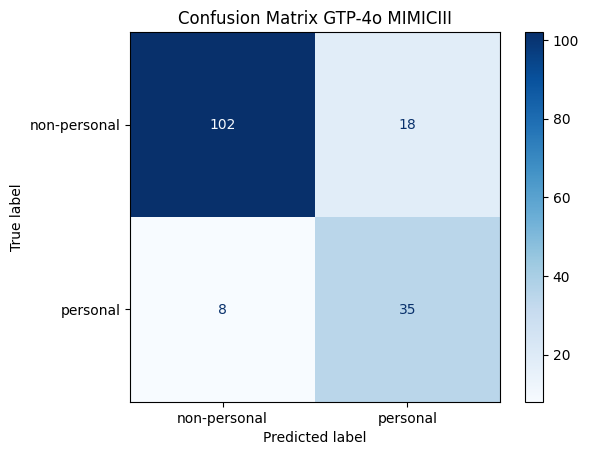

In [209]:
# Compute confusion matrix
cmmimic03 = confusion_matrix(y_true_Mimic1new1, y_pred_Mimic1new1)

# Create a ConfusionMatrixDisplay object
dispmimic = ConfusionMatrixDisplay(confusion_matrix=cmmimic03, display_labels=['non-personal', 'personal'])

# Plot the confusion matrix
dispmimic.plot(cmap=plt.cm.Blues)  # You can customize the colormap here
plt.title('Confusion Matrix GTP-4o MIMICIII')
plt.show()

In [179]:
y_true_Mimic1new1 = Mimic_labels
y_pred_Mimic1new1 = y_pred_mimic_gpt03new
target_names = ['non-personal', 'personal']
print(classification_report(y_true_Mimic1new1, y_pred_Mimic1new1, target_names=target_names, zero_division=1))
f1_mimic_micro11new1 = f1_score(y_true_Mimic1new1, y_pred_Mimic1new1, average="micro")
print(f'micro f1:{f1_mimic_micro11new1}')
f1_mimic_macro11new1 = f1_score(y_true_Mimic1new1, y_pred_Mimic1new1, average="macro")
print(f'macro f1:{f1_mimic_macro11new1}')
f1_mimic_weighted11new1 = f1_score(y_true_Mimic1new1, y_pred_Mimic1new1, average="weighted")
print(f'weighted f1:{f1_mimic_weighted11new1}')

Balanced_accuracymimic11new1 = balanced_accuracy_score(y_true_Mimic1new1, y_pred_Mimic1new1)
print(f'Balanced accuracy:{Balanced_accuracymimic11new1}')

              precision    recall  f1-score   support

non-personal       0.88      0.82      0.85       118
    personal       0.60      0.71      0.65        45

    accuracy                           0.79       163
   macro avg       0.74      0.77      0.75       163
weighted avg       0.81      0.79      0.80       163

micro f1:0.7914110429447853
macro f1:0.751969208736126
weighted f1:0.7962654225396972
Balanced accuracy:0.766572504708098


       Eval MIMIC 03 New 100

In [180]:
predict_gpt_mimic03new100 = pd.read_csv('../GPT/mimic_predictions_batch_gpt03New_1001.csv')
#predict_gpt_kag07['batch_gpt_prediction']= predict_gpt_kag07['batch_gpt_prediction'].fillna('')
y_pred_mimic_gpt03new100 = load_predictions_other_csv(predict_gpt_mimic03new100)

In [181]:
Mimic_labels03 = pd.read_csv('/home/aagisha/Documents/PhD Albert/CodingPhDStart1/Bachelor Projects HSAA/PIIDETECTION/Personal-Detection/datasets/MIMICIIIandHonda/fmimic_labels1.csv')

In [185]:
# Mimic_labels

In [211]:
y_true_Mimic1new113 = Mimic_labels03
y_pred_Mimic1new113 = y_pred_mimic_gpt03new100
target_names = ['non-personal', 'personal']
print(classification_report(y_true_Mimic1new113, y_pred_Mimic1new113, target_names=target_names, zero_division=1))
f1_mimic_micro11new113 = f1_score(y_true_Mimic1new113, y_pred_Mimic1new113, average="micro")
print(f'micro f1:{f1_mimic_micro11new113}')
f1_mimic_macro11new113 = f1_score(y_true_Mimic1new113, y_pred_Mimic1new113, average="macro")
print(f'macro f1:{f1_mimic_macro11new113}')
f1_mimic_weighted11new113 = f1_score(y_true_Mimic1new113, y_pred_Mimic1new113, average="weighted")
print(f'weighted f1:{f1_mimic_weighted11new113}')

Balanced_accuracymimic11new113 = balanced_accuracy_score(y_true_Mimic1new113, y_pred_Mimic1new113)
print(f'Balanced accuracy:{Balanced_accuracymimic11new113}')

              precision    recall  f1-score   support

non-personal       0.94      0.87      0.90       120
    personal       0.69      0.84      0.76        43

    accuracy                           0.86       163
   macro avg       0.81      0.85      0.83       163
weighted avg       0.87      0.86      0.86       163

micro f1:0.8588957055214724
macro f1:0.8291638186375029
weighted f1:0.8628308081972919
Balanced accuracy:0.8519379844961241


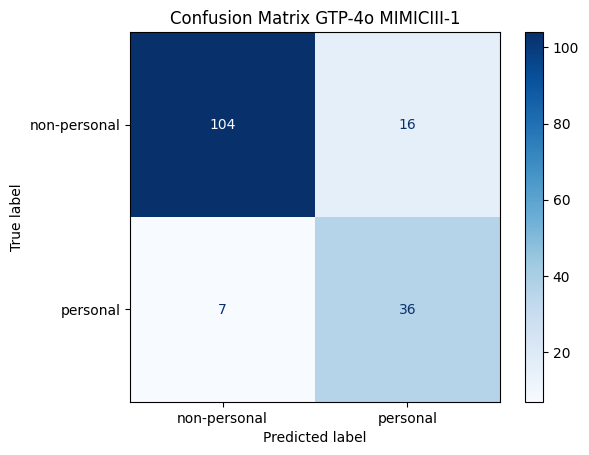

In [212]:
# Compute confusion matrix
cmmimic031 = confusion_matrix(y_true_Mimic1new113, y_pred_Mimic1new113)

# Create a ConfusionMatrixDisplay object
dispmimic1 = ConfusionMatrixDisplay(confusion_matrix=cmmimic031, display_labels=['non-personal', 'personal'])

# Plot the confusion matrix
dispmimic1.plot(cmap=plt.cm.Blues)  # You can customize the colormap here
plt.title('Confusion Matrix GTP-4o MIMICIII-1')
plt.show()


In [172]:
predict_gpt_mimic03new1001 = predict_gpt_mimic03new100.copy()

In [173]:
predict_gpt_mimic03new1001['batch_gpt_prediction'] = y_pred_mimic_gpt03new100

In [174]:
predict_gpt_mimic03new1001['True labels']= Mimic_labels03

In [175]:
predict_gpt_mimic03new1001.loc[(predict_gpt_mimic03new1001['batch_gpt_prediction']=='non-personal') & (predict_gpt_mimic03new1001['True labels']=='personal')]

,Feature,batch_gpt_prediction,True labels
57,linkorderid,non-personal,personal
86,cpt_number,non-personal,personal
88,ticket_id_seq,non-personal,personal
122,drug,non-personal,personal
148,updatetime,non-personal,personal
153,location,non-personal,personal
154,locationcategory,non-personal,personal


In [176]:
predict_gpt_mimic03new1001

,Feature,batch_gpt_prediction,True labels
0,row_id,non-personal,non-personal
1,subject_id,personal,personal
2,hadm_id,personal,personal
3,icustay_id,personal,personal
4,dbsource,non-personal,non-personal
...,...,...,...
158,last_wardid,non-personal,non-personal
159,drg_type,non-personal,non-personal
160,drg_code,non-personal,non-personal
161,drg_severity,non-personal,non-personal


        Eval Mimic New 1

In [133]:
predict_gpt_mimic01new = pd.read_csv('../GPT/mimic_predictions_batch_gpt01New.csv')
#predict_gpt_kag07['batch_gpt_prediction']= predict_gpt_kag07['batch_gpt_prediction'].fillna('')
y_pred_mimic_gpt01new = load_predictions_other_csv(predict_gpt_mimic01new)

In [134]:
y_true_Mimic1new11 = Mimic_labels
y_pred_Mimic1new11 = y_pred_mimic_gpt01new
target_names = ['non-personal', 'personal']
print(classification_report(y_true_Mimic1new11, y_pred_Mimic1new11, target_names=target_names, zero_division=1))
f1_mimic_micro11new11 = f1_score(y_true_Mimic1new11, y_pred_Mimic1new11, average="micro")
print(f'micro f1:{f1_mimic_micro11new11}')
f1_mimic_macro11new11 = f1_score(y_true_Mimic1new11, y_pred_Mimic1new11, average="macro")
print(f'macro f1:{f1_mimic_macro11new11}')
f1_mimic_weighted11new11 = f1_score(y_true_Mimic1new11, y_pred_Mimic1new11, average="weighted")
print(f'weighted f1:{f1_mimic_weighted11new11}')

Balanced_accuracymimic11new11 = balanced_accuracy_score(y_true_Mimic1new11, y_pred_Mimic1new11)
print(f'Balanced accuracy:{Balanced_accuracymimic11new11}')

              precision    recall  f1-score   support

non-personal       0.88      0.67      0.76       118
    personal       0.47      0.76      0.58        45

    accuracy                           0.69       163
   macro avg       0.67      0.71      0.67       163
weighted avg       0.76      0.69      0.71       163

micro f1:0.6932515337423313
macro f1:0.6679432855280313
weighted f1:0.7089988881867846
Balanced accuracy:0.7125235404896422


In [190]:
# y_pred_mimic_gpt01new

In [84]:
from collections import Counter

my_list1 = y_pred_mimic_gpt01new
counter1 = Counter(my_list1)
print(counter1)

Counter({'non-personal': 163})


In [85]:
y_true_Mimic1new11 = Mimic_labels
y_pred_Mimic1new11 = y_pred_mimic_gpt01new
target_names = ['non-personal', 'personal']
print(classification_report(y_true_Mimic1new11, y_pred_Mimic1new11, target_names=target_names, zero_division=1))
f1_mimic_micro11new11 = f1_score(y_true_Mimic1new11, y_pred_Mimic1new11, average="micro")
print(f'micro f1:{f1_mimic_micro11new11}')
f1_mimic_macro11new11 = f1_score(y_true_Mimic1new11, y_pred_Mimic1new11, average="macro")
print(f'macro f1:{f1_mimic_macro11new11}')
f1_mimic_weighted11new11 = f1_score(y_true_Mimic1new11, y_pred_Mimic1new11, average="weighted")
print(f'weighted f1:{f1_mimic_weighted11new11}')

Balanced_accuracymimic11new11 = balanced_accuracy_score(y_true_Mimic1new11, y_pred_Mimic1new11)
print(f'Balanced accuracy:{Balanced_accuracymimic11new11}')

              precision    recall  f1-score   support

non-personal       0.72      1.00      0.84       118
    personal       1.00      0.00      0.00        45

    accuracy                           0.72       163
   macro avg       0.86      0.50      0.42       163
weighted avg       0.80      0.72      0.61       163

micro f1:0.7239263803680982
macro f1:0.4199288256227758
weighted f1:0.6079951094906446
Balanced accuracy:0.5


All Confusion Matrices

In [213]:
import plotly.figure_factory as ff
import numpy as np
from sklearn.metrics import confusion_matrix

# Function to create a heatmap for confusion matrices
def create_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    labels = ['Non-Personal', 'Personal']

    fig = ff.create_annotated_heatmap(
        z=cm, x=labels, y=labels, colorscale="Blues",
        showscale=True, reversescale=False
    )
    
    fig.update_layout(
        title=title,
        xaxis=dict(title="Predicted Label"),
        yaxis=dict(title="True Label"),
        font=dict(size=14)
    )
    
    return fig

# Create figures
fig1 = create_confusion_matrix(y_true_dessib, y_pred_dessib, "Confusion Matrix: GTP-4o DESSI-MF")
fig2 = create_confusion_matrix(y_true_kag1, y_pred_kag1, "Confusion Matrix: GTP-4o Kaggle")
fig3 = create_confusion_matrix(y_true_openall, y_pred_openall, "Confusion Matrix: GTP-4o OpenML")
fig4 = create_confusion_matrix(y_true_Mimic1new113, y_pred_Mimic1new113, "Confusion Matrix: GTP-4o MIMIC-ext")

# Display two by two side by side
fig1.show()
fig2.show()
fig3.show()
fig4.show()


In [215]:
!pip install -U kaleido

  Using cached kaleido-0.2.1-py2.py3-none-manylinux1_x86_64.whl.metadata (15 kB)
Using cached kaleido-0.2.1-py2.py3-none-manylinux1_x86_64.whl (79.9 MB)


In [220]:
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from sklearn.metrics import confusion_matrix

# Function to create a heatmap for confusion matrices
def create_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    labels = ['Non-Personal', 'Personal']

    heatmap = ff.create_annotated_heatmap(
        z=cm, x=labels, y=labels, colorscale="Blues",
        showscale=False, reversescale=False
    )

    heatmap.layout.update(title=title)
    
    return heatmap

# Create subplots for 2x2 layout
fig = make_subplots(
    rows=2, cols=2, 
    subplot_titles=(
        "Confusion Matrix: GTP-4o DESSI-MF", 
        "Confusion Matrix: GTP-4o Kaggle", 
        "Confusion Matrix: GTP-4o OpenML", 
        "Confusion Matrix: GTP-4o MIMIC-ext"
    )
)

# Generate heatmaps
heatmaps = [
    create_confusion_matrix(y_true_dessib, y_pred_dessib, "Confusion Matrix: GTP-4o DESSI-MF"),
    create_confusion_matrix(y_true_kag1, y_pred_kag1, "Confusion Matrix: GTP-4o Kaggle"),
    create_confusion_matrix(y_true_openall, y_pred_openall, "Confusion Matrix: GTP-4o OpenML"),
    create_confusion_matrix(y_true_Mimic1new113, y_pred_Mimic1new113, "Confusion Matrix: GTP-4o MIMIC-ext")
]

# Add heatmaps to subplots
for i, heatmap in enumerate(heatmaps):
    for trace in heatmap.data:
        fig.add_trace(trace, row=(i//2) + 1, col=(i%2) + 1)

# Update layout
fig.update_layout(
    title="Confusion Matrices (2x2 Layout)",
    height=800, width=800
)

# Show figure
fig.show()

# # Save as an image
# fig.write_image("confusion_matrices.png")


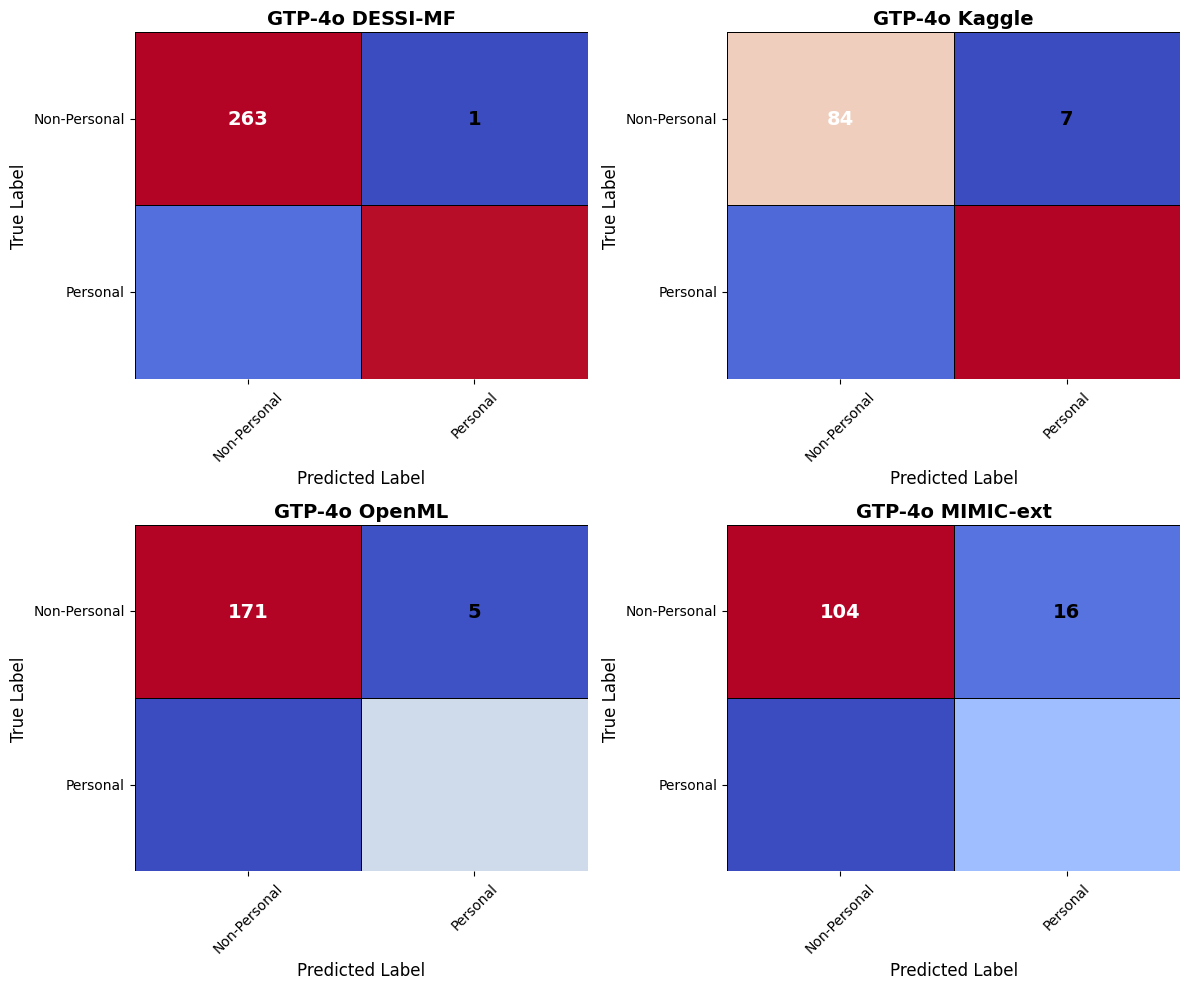

In [223]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Function to plot a confusion matrix with better contrast
def plot_confusion_matrix(ax, y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    labels = ['Non-Personal', 'Personal']
    
    # Custom color map
    cmap = "coolwarm"  # Better contrast than "Blues"
    
    # Create heatmap with dynamically colored text
    heatmap = sns.heatmap(
        cm, annot=True, fmt="d", cmap=cmap, xticklabels=labels, yticklabels=labels,
        linewidths=0.5, linecolor='black', cbar=False, ax=ax, 
        annot_kws={"size": 14, "weight": "bold"}
    )

    # Set title and labels
    ax.set_title(title, fontsize=14, weight="bold")
    ax.set_xlabel("Predicted Label", fontsize=12)
    ax.set_ylabel("True Label", fontsize=12)

    # Rotate labels for better readability
    ax.xaxis.set_tick_params(rotation=45)
    ax.yaxis.set_tick_params(rotation=0)

    # Adjust text color based on background intensity
    for text in ax.texts:
        text_value = int(text.get_text())  # Get confusion matrix value
        if text_value > (cm.max() / 2):  # High values → white text
            text.set_color("white")
        else:  # Low values → black text
            text.set_color("black")

# Create a 2x2 figure with better spacing
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot confusion matrices
plot_confusion_matrix(axes[0, 0], y_true_dessib, y_pred_dessib, "GTP-4o DESSI-MF")
plot_confusion_matrix(axes[0, 1], y_true_kag1, y_pred_kag1, "GTP-4o Kaggle")
plot_confusion_matrix(axes[1, 0], y_true_openall, y_pred_openall, "GTP-4o OpenML")
plot_confusion_matrix(axes[1, 1], y_true_Mimic1new113, y_pred_Mimic1new113, "GTP-4o MIMIC-ext")

# Adjust layout
plt.tight_layout()

# Save high-resolution figure for publication
plt.savefig("confusion_matrices_paper.png", dpi=400, bbox_inches='tight')

# Show the plot
plt.show()


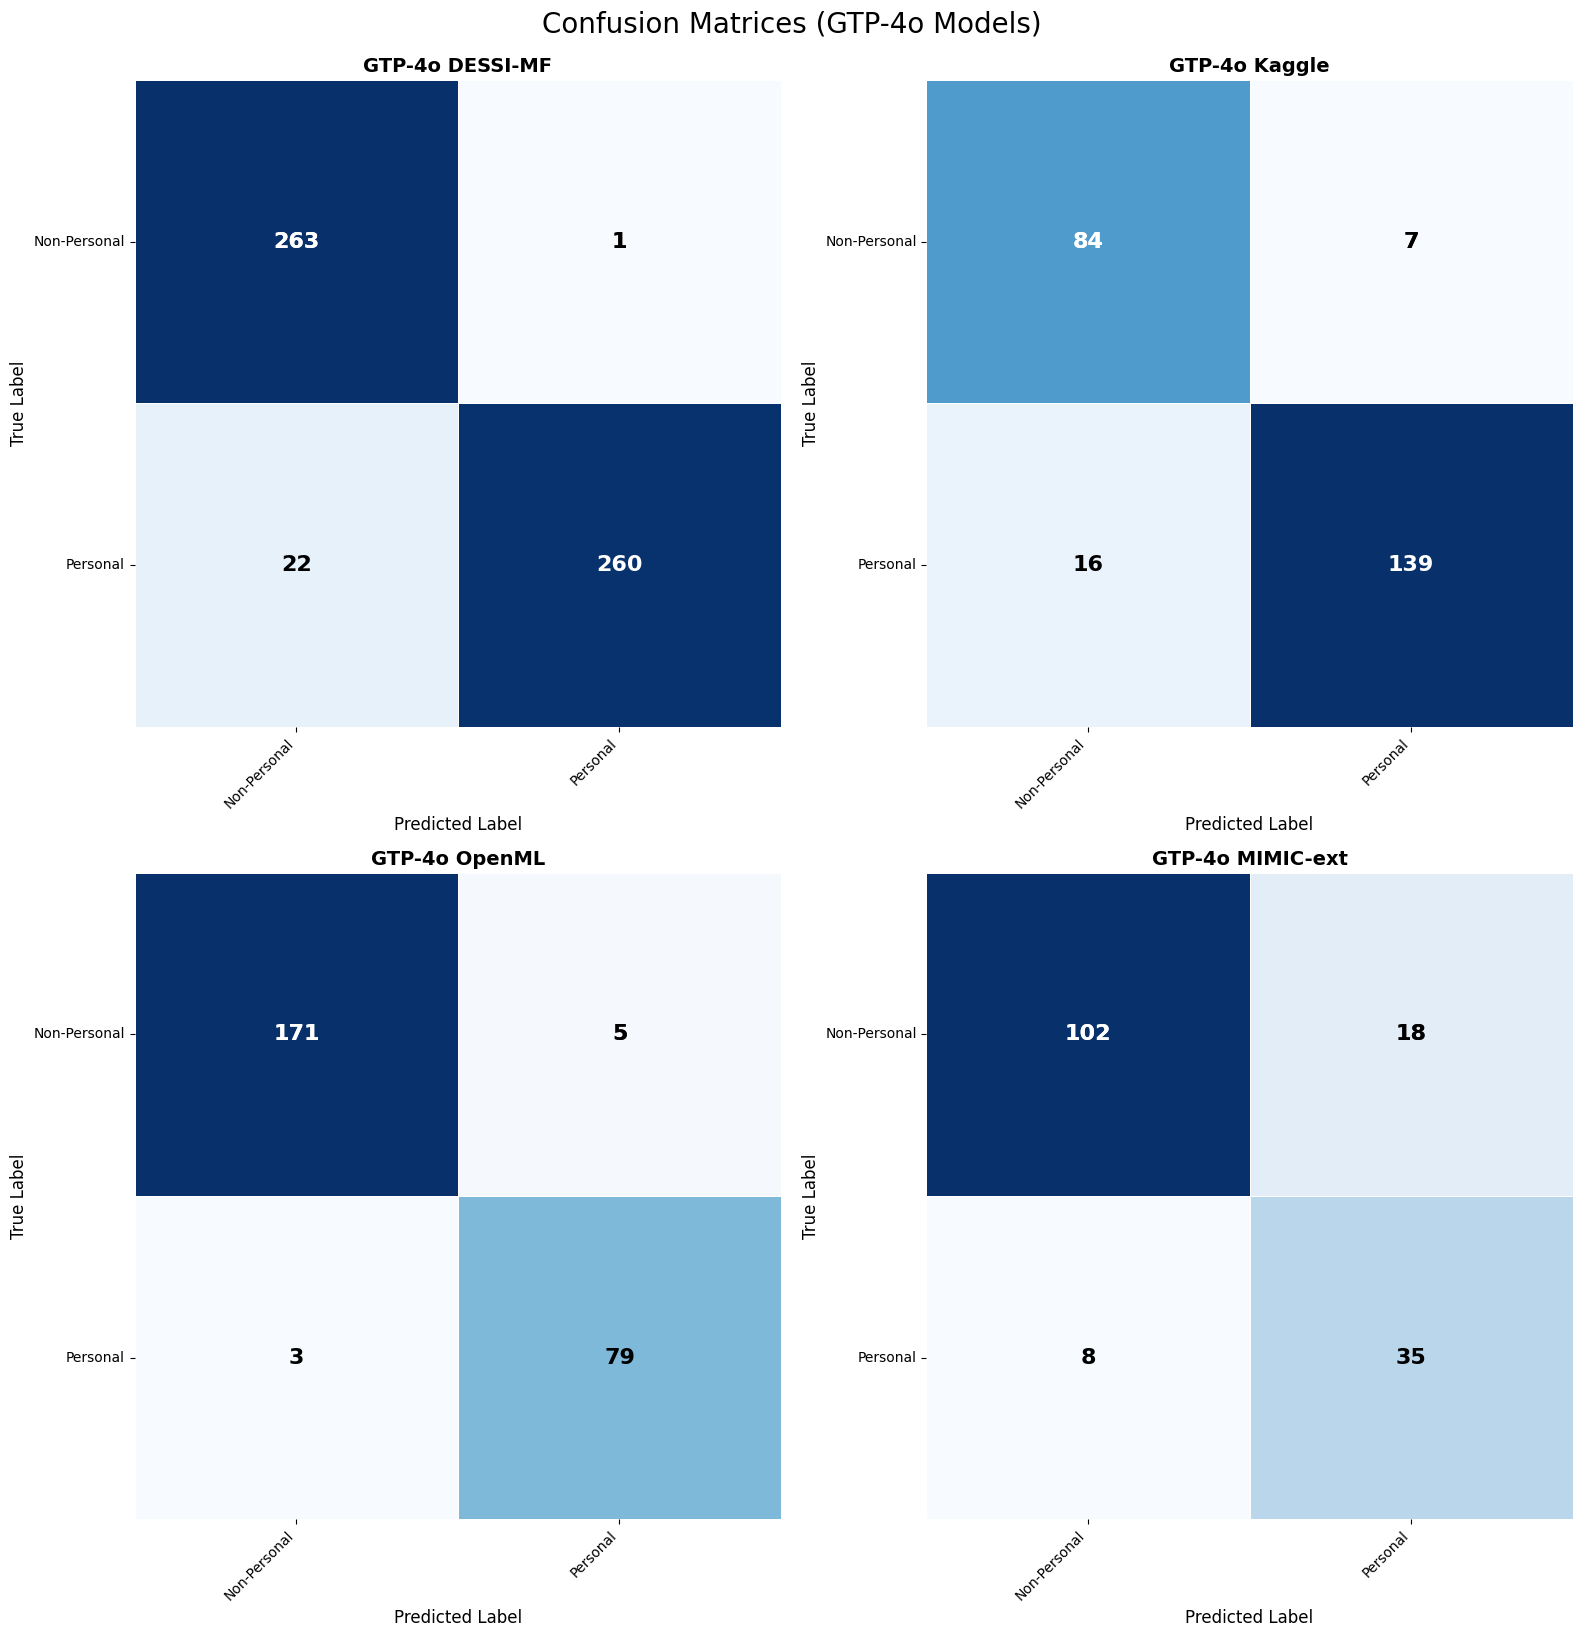

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(ax, y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False,
                annot_kws={"size": 16, "weight": "bold"},
                square=True, linewidths=0.5)
    
    # Manually add text for each cell
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j+0.5, i+0.5, str(cm[i, j]),
                    ha="center", va="center",
                    color="white" if cm[i, j] > cm.max()/2 else "black",
                    fontsize=16, fontweight='bold')
    
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xticklabels(['Non-Personal', 'Personal'], rotation=45, ha='right')
    ax.set_yticklabels(['Non-Personal', 'Personal'], rotation=0)

# Create a 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(16, 16))
axes = axes.flatten()

# Plot each confusion matrix
plot_confusion_matrix(axes[0], y_true_dessib, y_pred_dessib, "GTP-4o DESSI-MF")
plot_confusion_matrix(axes[1], y_true_kag1, y_pred_kag1, "GTP-4o Kaggle")
plot_confusion_matrix(axes[2], y_true_openall, y_pred_openall, "GTP-4o OpenML")
plot_confusion_matrix(axes[3], y_true_Mimic1new1, y_pred_Mimic1new1, "GTP-4o MIMIC-ext")

# Adjust the layout and add a main title
plt.tight_layout()
fig.suptitle("Confusion Matrices (GTP-4o Model)", fontsize=20, y=1.02)

# Save the figure as a high-resolution image
plt.savefig("confusion_matrices_paper.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


CASSED

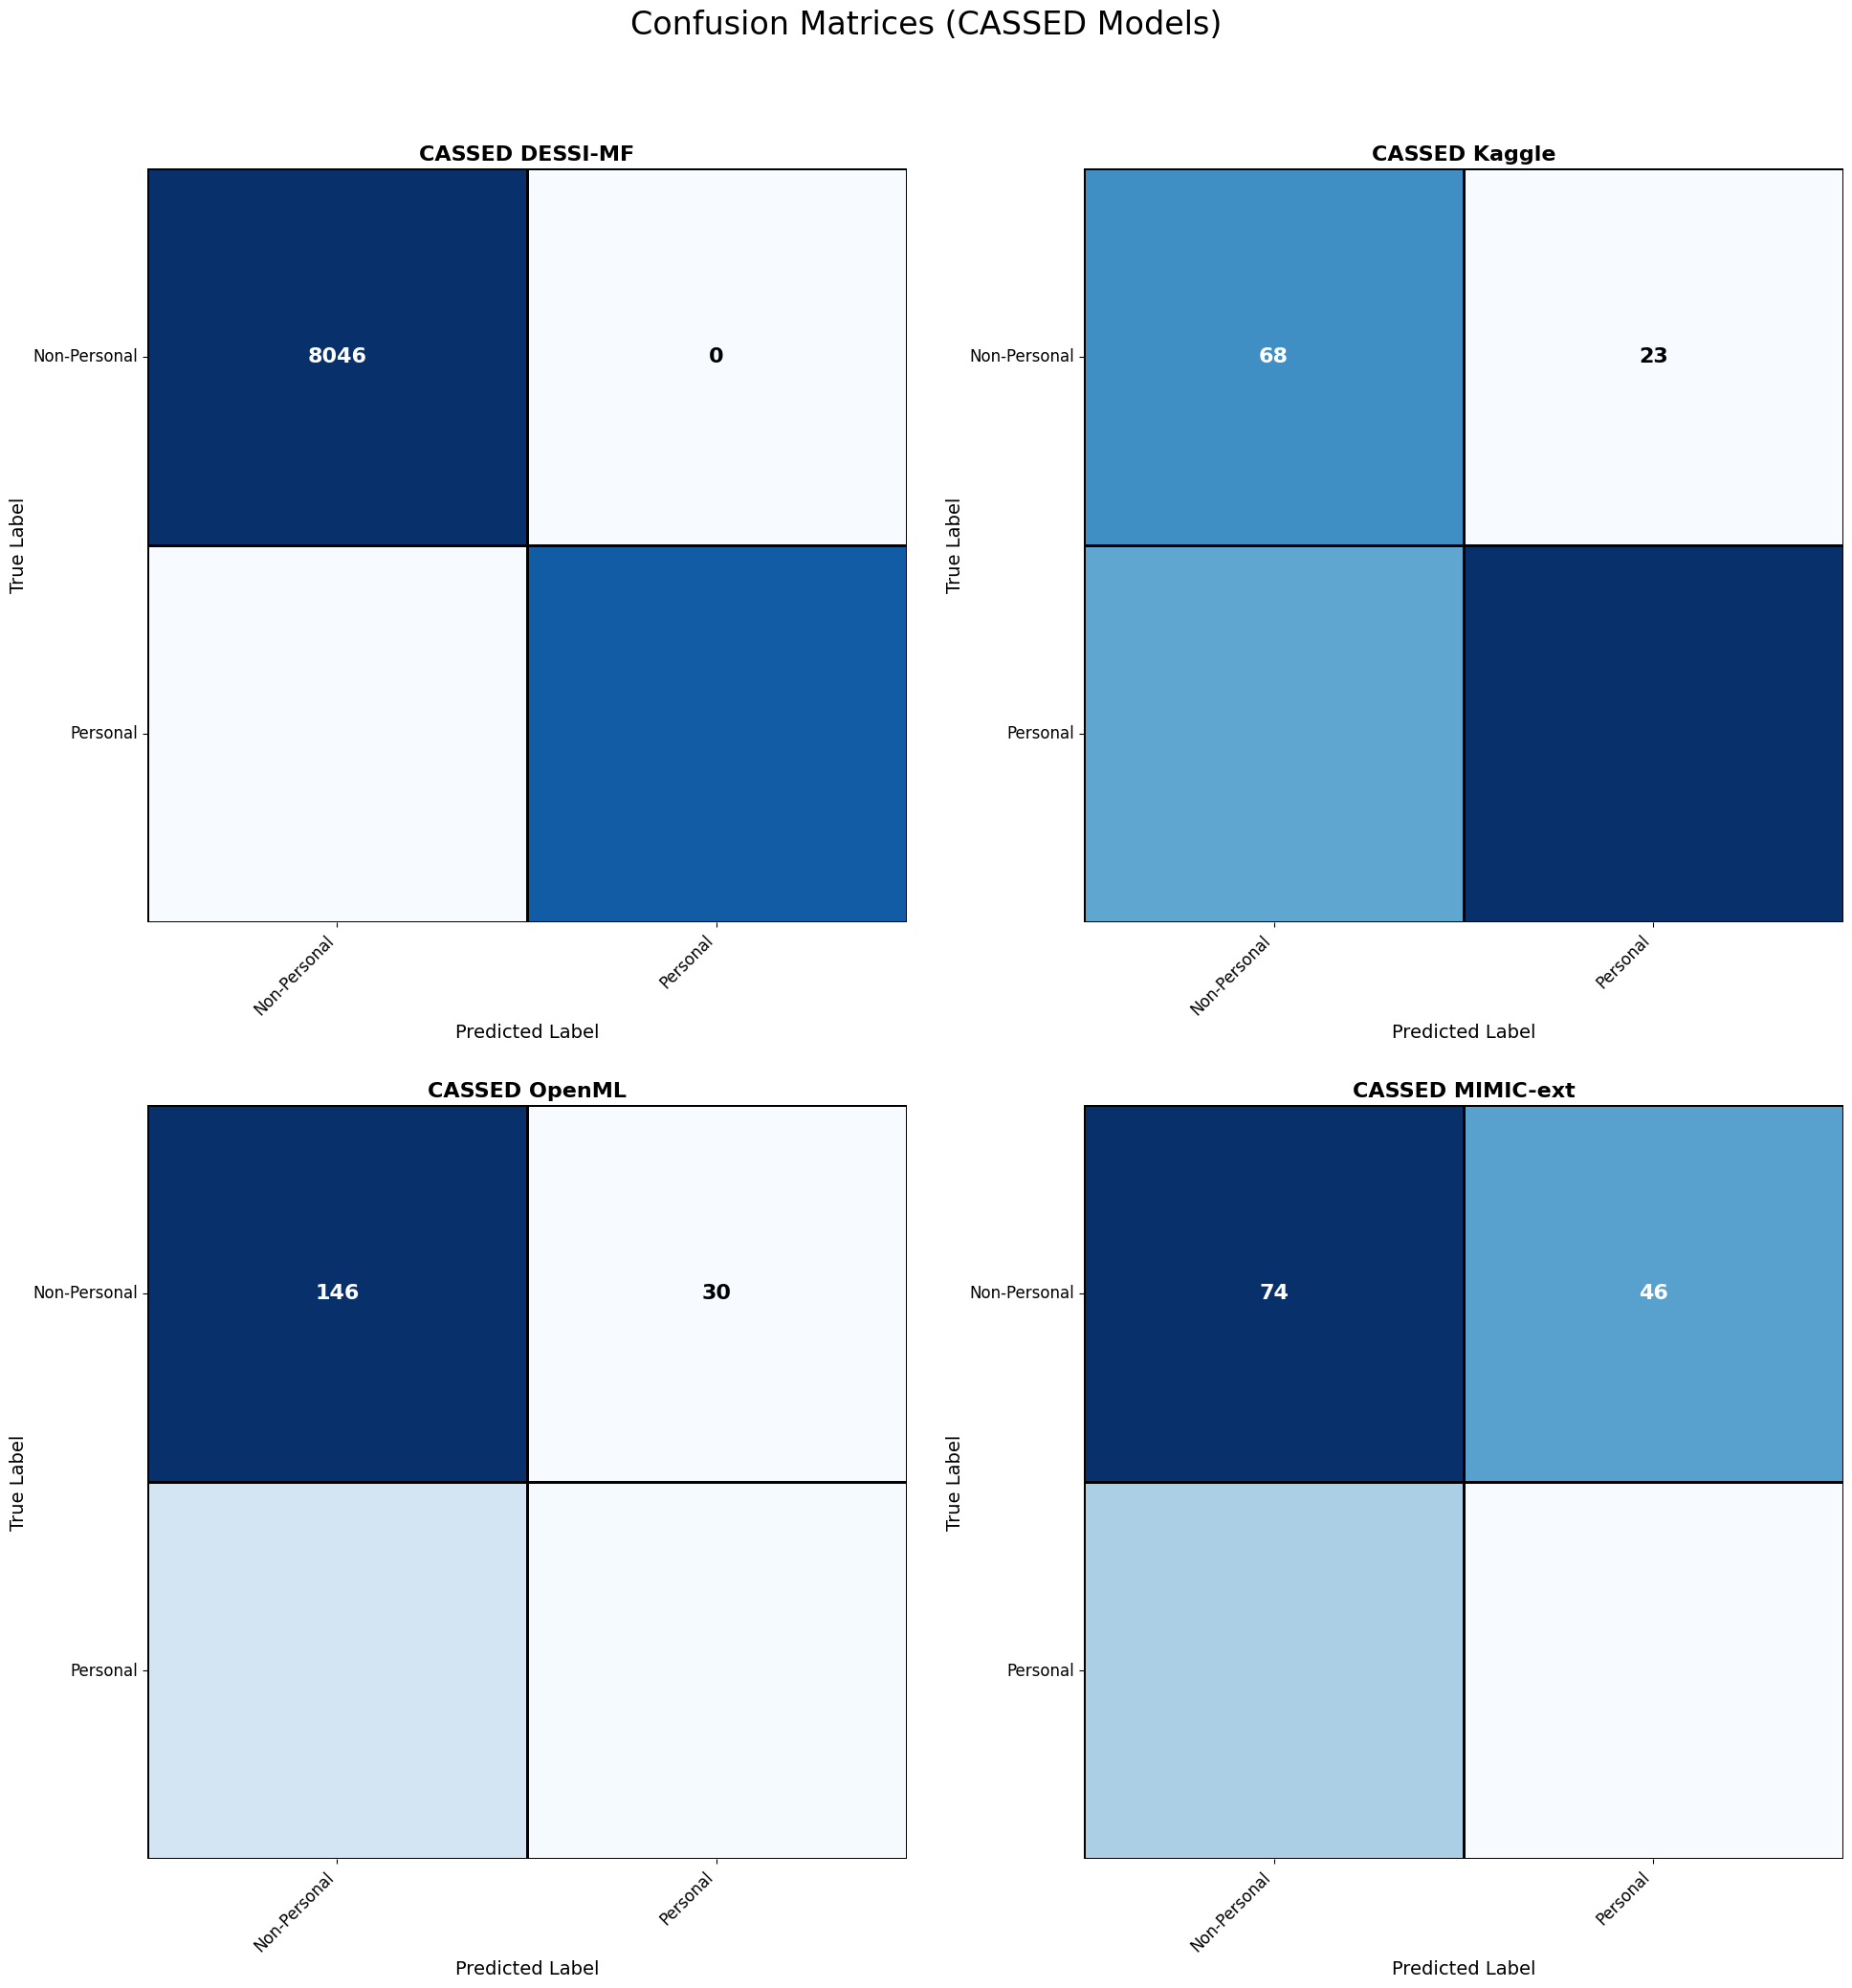

In [234]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Function to plot a confusion matrix with proper visibility for all values
def plot_confusion_matrix(ax, cm, title):
    # Create a heatmap
    heatmap = sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        ax=ax,
        cbar=False,
        linewidths=1,  # Add clear borders between cells
        linecolor='black',
        annot_kws={"size": 16, "weight": "bold"}  # Ensure annotations are bold and readable
    )
    
    # Dynamically adjust text color based on cell value for better visibility
    for text in heatmap.texts:
        value = int(text.get_text())
        text_color = 'white' if value > cm.max() / 2 else 'black'
        text.set_color(text_color)
    
    # Set labels and title
    ax.set_xlabel('Predicted Label', fontsize=14)
    ax.set_ylabel('True Label', fontsize=14)
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_xticklabels(['Non-Personal', 'Personal'], rotation=45, ha='right', fontsize=12)
    ax.set_yticklabels(['Non-Personal', 'Personal'], rotation=0, fontsize=12)

# Create a 2x2 subplot grid with increased figure size
fig, axes = plt.subplots(2, 2, figsize=(20, 20))  # Larger figure size ensures proper scaling
axes = axes.flatten()

# Define confusion matrices for each dataset
cms = [
    np.array([[8046, 0], [0, 6692]]),   # DESSI
    np.array([[68, 23], [61, 94]]),    # Kaggle
    np.array([[146, 30], [51, 31]]),   # OpenML
    np.array([[74, 46], [32, 11]])     # MIMIC
]

# Titles for each confusion matrix
titles = ["CASSED DESSI-MF", "CASSED Kaggle", "CASSED OpenML", "CASSED MIMIC-ext"]

# Plot each confusion matrix with proper formatting
for i, (cm, title) in enumerate(zip(cms, titles)):
    plot_confusion_matrix(axes[i], cm, title)

# Adjust layout and add a main title
plt.tight_layout(pad=3.0)  # Increase padding for better spacing between subplots
fig.suptitle("Confusion Matrices (CASSED Models)", fontsize=24, y=1.05)

# Save the figure as a high-resolution image for publication
plt.savefig("confusion_matrices_cassed_fixed.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()
